In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import sys
from scipy import stats

In [8]:
def summary(data):
    hist = sns.distplot(data, kde=False)
    hist.set_title('Histogram of Offers')
    plt.show()
    fig = hist.get_figure()
    fig.savefig('~/eBay/data/hist.png')
    box = sns.boxplot(x=data)
    box.show()
    box.savefig('~/eBay/data/box.png')
    print(describe(data))

In [9]:
def get_percentiles(offr):
    offr = np.sort(offr)
    print('Min: %.2f' % np.amin(offr))
    print('0.5%% : %.2f' % np.percentile(offr, .5, interpolation='nearest'))
    print('1%% : %.2f' % np.percentile(offr, 1, interpolation='nearest'))
    print('5%% : %.2f' % np.percentile(offr, 5, interpolation='nearest'))
    print('10%% : %.2f' % np.percentile(offr, 10, interpolation='nearest'))
    print('25%% : %.2f' % np.percentile(offr, 25, interpolation='nearest'))
    print('50%% : %.2f' % np.percentile(offr, 50, interpolation='nearest'))
    print('75%% : %.2f' % np.percentile(offr, 75, interpolation='nearest'))
    print('90%% : %.2f' % np.percentile(offr, 90, interpolation='nearest'))
    print('95%% : %.2f' % np.percentile(offr, 95, interpolation='nearest'))
    print('99%% : %.2f' % np.percentile(offr, 99, interpolation='nearest'))
    print('99.5%% : %.2f' % np.percentile(offr, 99.5, interpolation='nearest'))
    print('Max : %.2f' % np.amax(offr))

In [75]:
def check_bins(offr):
    # creates num_obv x 2 np.array where the first column
    # corresponds to observations and the second column to their frequencies
    freq_table = np.unique(offr, return_counts = True)
    freq_table = np.column_stack([freq_table[0], freq_table[1]])
    # reverse sort rows by descending order of the second column (ie frequency)
    freq_table = freq_table[freq_table[:, 1].argsort()[::-1]]

    # extract top percentiles of observations
    top_one = freq_table[0:int(freq_table.shape[0] * .01), 0]
    top_two = freq_table[0:int(freq_table.shape[0] * .02), 0]
    top_ten = freq_table[0:int(freq_table.shape[0] * .1), 0]
    top_five = freq_table[0:int(freq_table.shape[0] * .05), 0]

    # collect
    # bin_array = [top_one, top_two, top_ten, top_five]
    # bin_names = ['1%', '2%', '10%', '5%']
    
    bin_array = [top_one, top_two]
    bin_names = ['1%', '2%']
    
    # grab the high
    right = np.amax(offr)
    left = np.amin(offr)

    for bin_cents, bin_name in zip(bin_array, bin_names):
        bin_cents = np.sort(bin_cents)
        odd_bin_cents = bin_cents[::2]
        ev_bin_cents = bin_cents[1::2]
        last_odd = None
        if bin_cents.size % 2 != 0:
            # extracting highest freq vals for even and odd freq vals
            last_odd = odd_bin_cents[(odd_bin_cents.size - 1)]
            last_even = ev_bin_cents[(ev_bin_cents.size - 1)]
            # finding highest midpoint
            highest_edge = (last_odd + last_even) / 2

            odd_bin_cents = odd_bin_cents[:(odd_bin_cents.size - 1)]
            low_edges = np.divide(np.add(odd_bin_cents, ev_bin_cents), 2)

            # remove lowest element from odd bin centers
            odd_bin_cents = odd_bin_cents[1:]
            # remove highest element from even bin centers
            ev_bin_cents = ev_bin_cents[:(ev_bin_cents.size - 1)]
            # find midpoint between every even freq val (except the highest)
            # and the odd freq val immediately above it
            high_edges = np.divide(np.add(ev_bin_cents, odd_bin_cents), 2)
            # adds highest edge to edge count
            high_edges = np.append(high_edges, highest_edge)
            edge_count = high_edges.size + low_edges.size + 2
            edges = np.zeros(edge_count)
            edges[0] = left
            edges[edge_count - 1] = right
            edges[1:(edge_count - 1):2] = low_edges
            edges[2:(edge_count):2] = high_edges
        else:
            # find midpoint between every even  freq val and the odd freq val
            # immediately below
            low_edges = np.divide(np.add(odd_bin_cents, ev_bin_cents), 2)
            # remove lowest element from odd bin centers
            odd_bin_cents = odd_bin_cents[1:]
            # remove highest element from even bin centers
            ev_bin_cents = ev_bin_cents[:(ev_bin_cents.size - 1)]

            # find midpoint between every even freq val (except the highest)
            # and the odd freq val immediately above it
            high_edges = np.divide(np.add(ev_bin_cents, odd_bin_cents), 2)

            # count total edges
            edge_count = low_edges.size + high_edges.size + 2

            # create edge vector
            edges = np.zeros(edge_count)
            edges[0] = left
            edges[edge_count - 1] = right
            edges[1:(edge_count):2] = low_edges
            edges[2:(edge_count - 1):2] = high_edges
        plt.figure(figsize=(11.5, 6), dpi=300)
        n, _, _ = plt.hist(offr, bins=edges)
        plt.suptitle('Histogram of Rounded Data')
        plt.title('(Rounded to %s of values)' % bin_name)
        max_bin = np.argmax(n)
        med_bin = np.median(n)
        n = np.sort(n)[::-1]
        print(n[0:10])
        # zoomed in plot
        highest_edge = np.amin(edges[edges > 1000])
        edges = edges[edges <= highest_edge]
        zoom = offr[offr <= np.amax(edges)]
        plt.figure(figsize=(11.5, 6), dpi=300)
        n, _, _ = plt.hist(zoom, bins=edges)
        plt.suptitle('Zoomed Histogram of Rounded Data (<= $1000)')
        plt.title('(Rounded to %s of values)' % bin_name)
        plt.show()
        
        highest_edge = np.amin(edges[edges > 500])
        edges = edges[edges <= highest_edge]
        zoom = offr[offr <= np.amax(edges)]
        plt.figure(figsize=(11.5, 6), dpi=300)
        n, _, _ = plt.hist(zoom, bins=edges)
        plt.suptitle('Zoomed Histogram of Rounded Data (<= $500)')
        plt.title('(Rounded to %s of values)' % bin_name)
        plt.show()
        
        highest_edge = np.amin(edges[edges > 100])
        edges = edges[edges <= highest_edge]
        zoom = offr[offr <= np.amax(edges)]
        plt.figure(figsize=(11.5, 6), dpi=300)
        n, _, _ = plt.hist(zoom, bins=edges)
        plt.suptitle('Zoomed Histogram of Rounded Data (<= $100)')
        plt.title('(Rounded to %s of values)' % bin_name)
        plt.show()
        
        highest_edge = np.amin(edges[edges > 50])
        edges = edges[edges <= highest_edge]
        zoom = offr[offr <= np.amax(edges)]
        plt.figure(figsize=(11.5, 6), dpi=300)
        n, _, _ = plt.hist(zoom, bins=edges)
        plt.suptitle('Zoomed Histogram of Rounded Data (<= $50)')
        plt.title('(Rounded to %s of values)' % bin_name)
        plt.show()
        
        # plt.savefig('~/eBay/data/hist' + bin_name[0:(len(bin_name) - 1)] + '.png')

In [52]:
def main():
    data = pd.read_csv('~/eBay/data/train.csv')
    offr = data['offr_price'].values
    summary(offr)
    check_bins(offr)

In [ ]:
# MAIN BLOCk
data = pd.read_csv('~/eBay/data/train.csv')
offr = data['offr_price'].values

In [71]:
offr = np.sort(offr)
print(np.percentile(offr, .5))
print(np.percentile(offr, 1))
print(np.percentile(offr, 5))
print(np.percentile(offr, 10))
print(np.percentile(offr, 25))
print(np.median(offr))
print(np.percentile(offr, 75))
print(np.percentile(offr, 90))
print(np.percentile(offr, 95))
print(np.percentile(offr, 99))
print(np.percentile(offr, 99.5))
counts = np.unique(offr, return_counts=True)

1.0
1.99
5.0
8.0
18.0
50.0
170.0
475.0
975.0
3900.0
6000.0


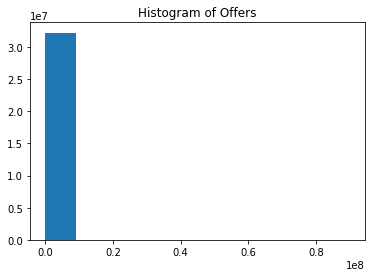

<Figure size 432x288 with 0 Axes>

In [43]:
hist = plt.hist(offr)
plt.title('Raw Histogram of Offers')
plt.show()
plt.savefig('/home/opim/eplu/eBay/data/hist.png')

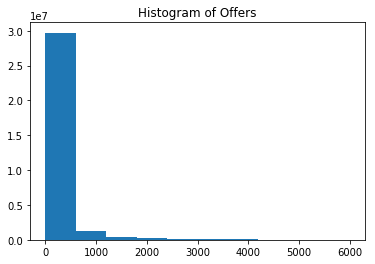

In [13]:
# Removing the 0.5% of most extreme offers (symmetric)
# (Someone made an offer for 90 million dollars if you're wondering about
# out the raw plot)
cut_offr = offr[offr <= 6000]
cut_offr = cut_offr[cut_offr >= 1]
hist = plt.hist(cut_offr)
plt.title('Histogram of Offers')
plt.savefig('/home/opim/eplu/eBay/data/cut_hist.png')
plt.show()

In [15]:
# grabbing most common values in original distribution
counts = np.unique(offr, return_counts=True)
car = np.column_stack([counts[0], counts[1]])
car = car[np.argsort(car[:, 1])[::-1]]
top_one = car[0:int(car.shape[0] * .01), 0]
print('Num Values: %d' % len(top_one))
get_percentiles(top_one)

Num Values: 573
Min: 0.99
0.5% : 1.50
1% : 2.00
5% : 5.55
10% : 9.25
25% : 25.99
50% : 98.00
75% : 430.00
90% : 1550.00
95% : 3100.00
99% : 8500.00
99.5% : 10000.00
Max : 15000.00


[1105405.  942053.  914540.  894061.  885651.  861661.  815019.  762556.
  614335.  580497.]


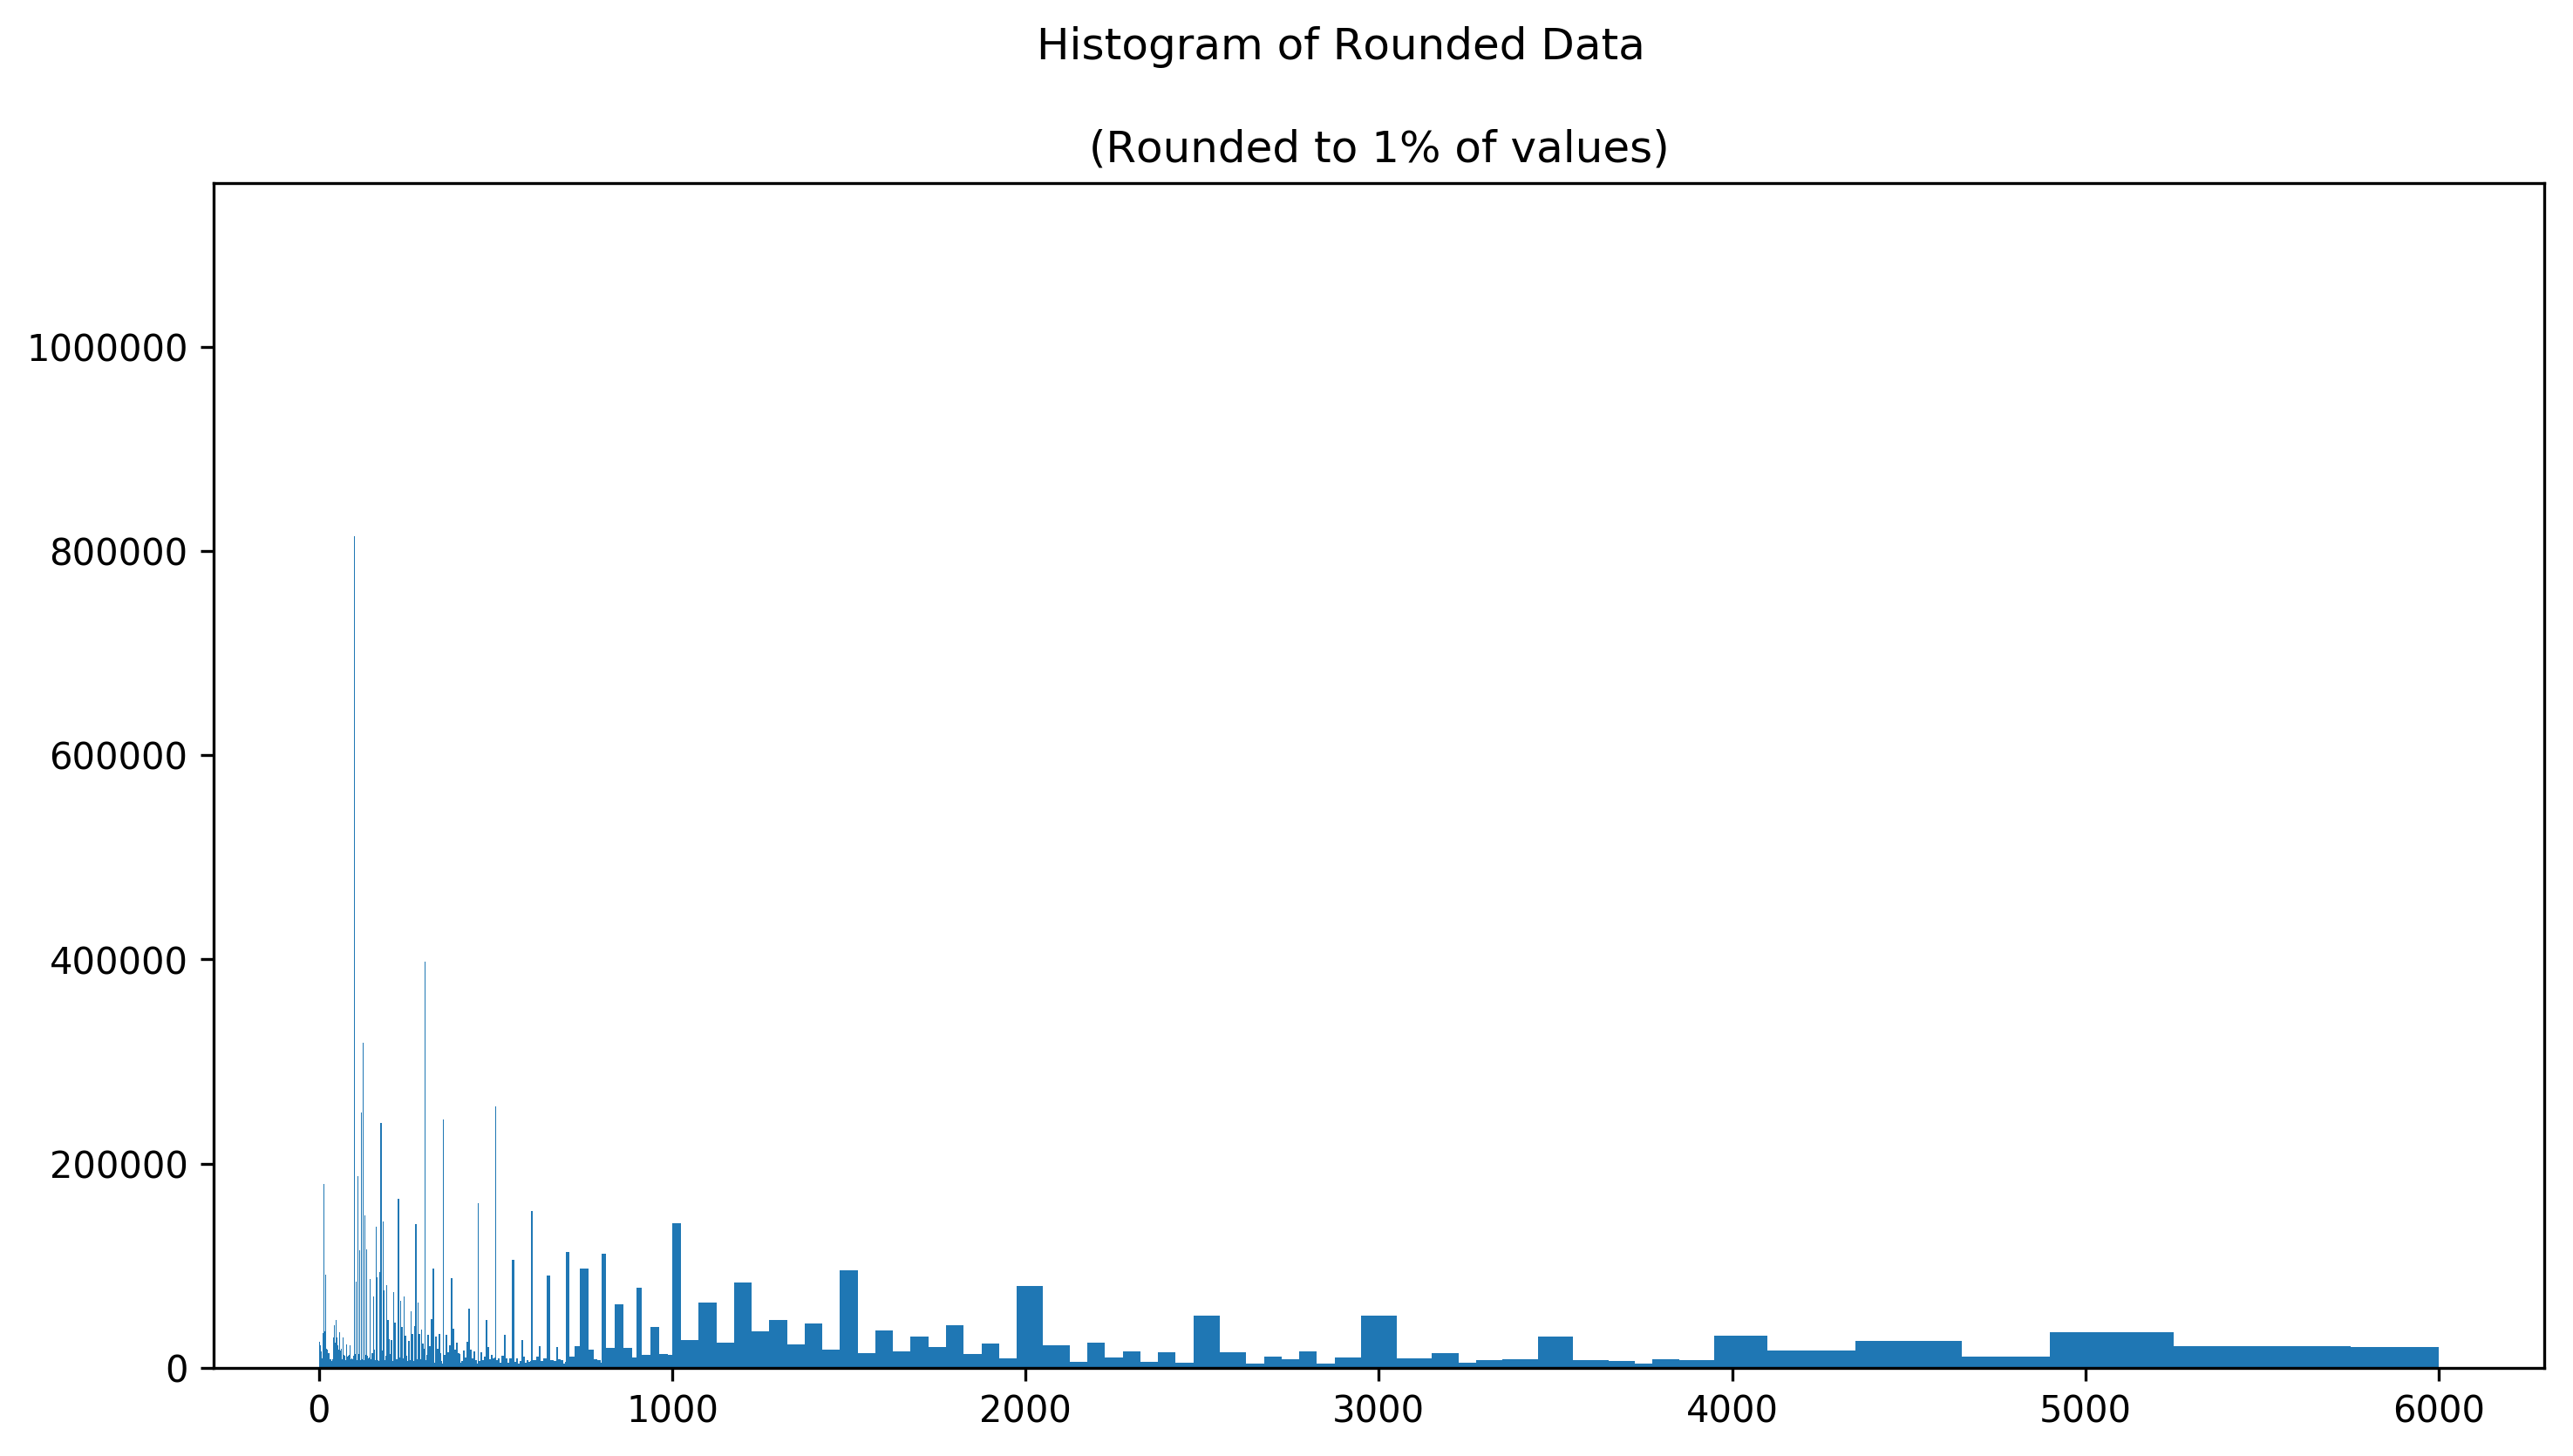

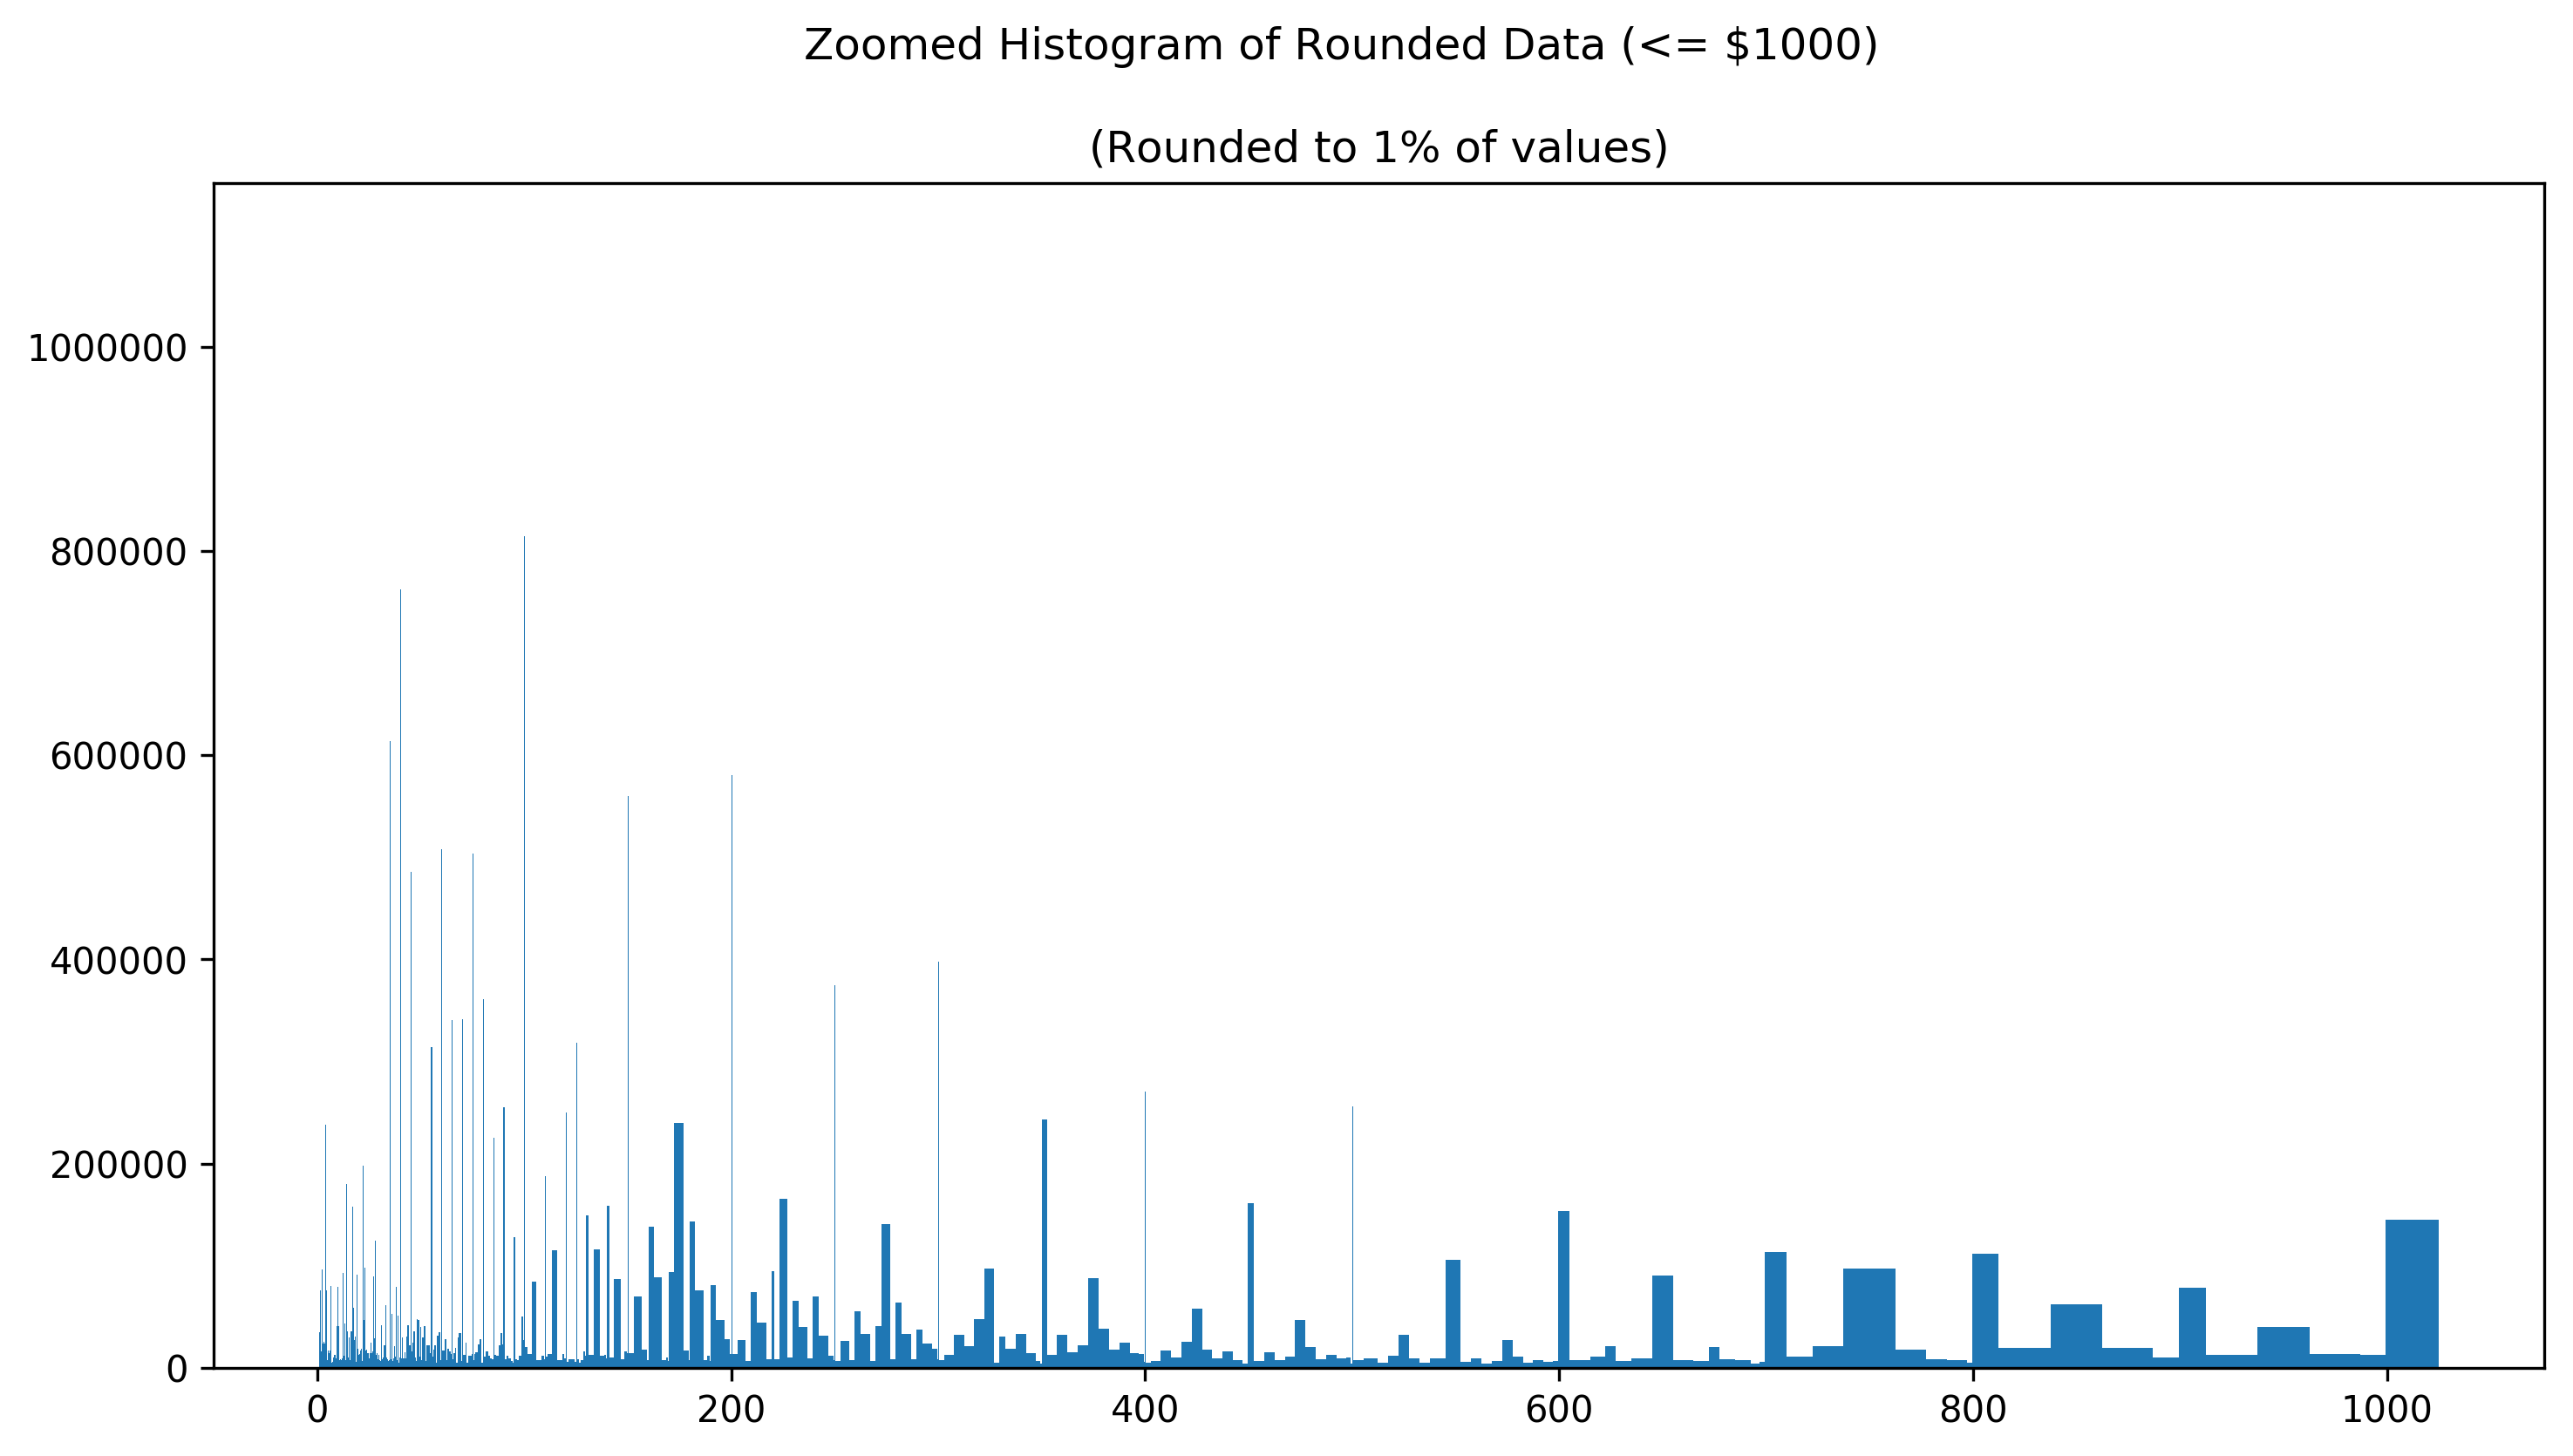

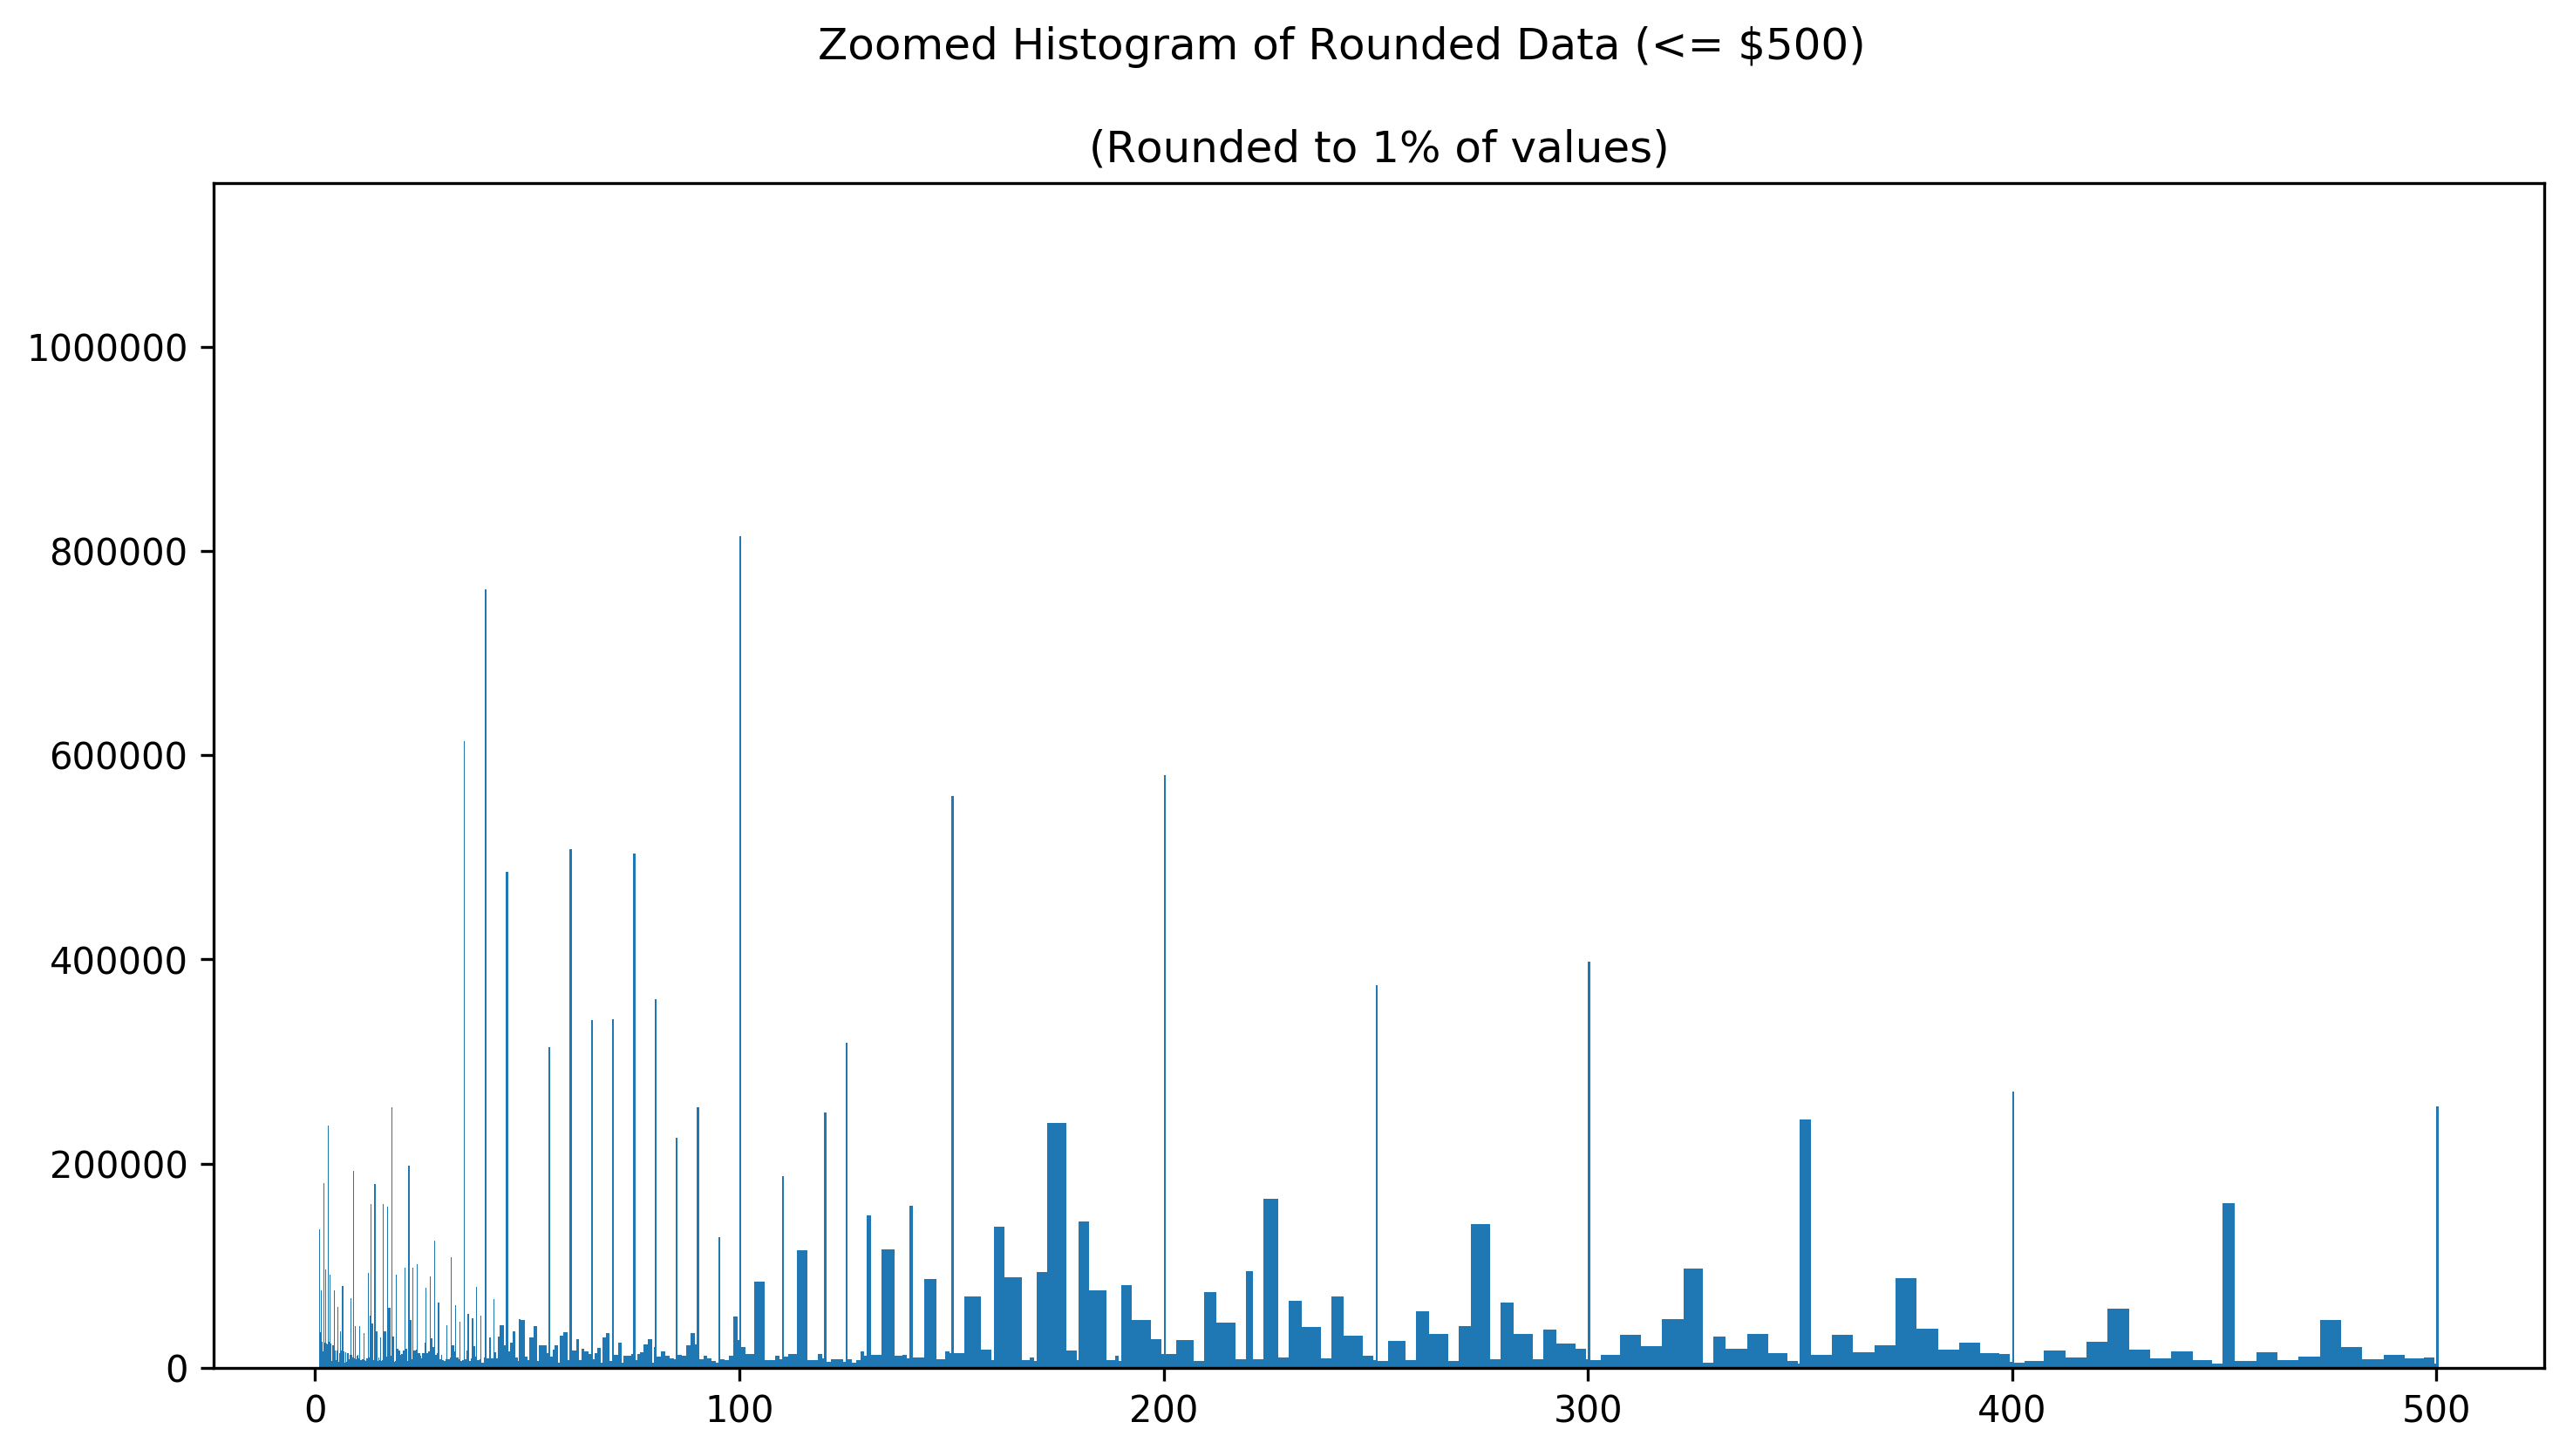

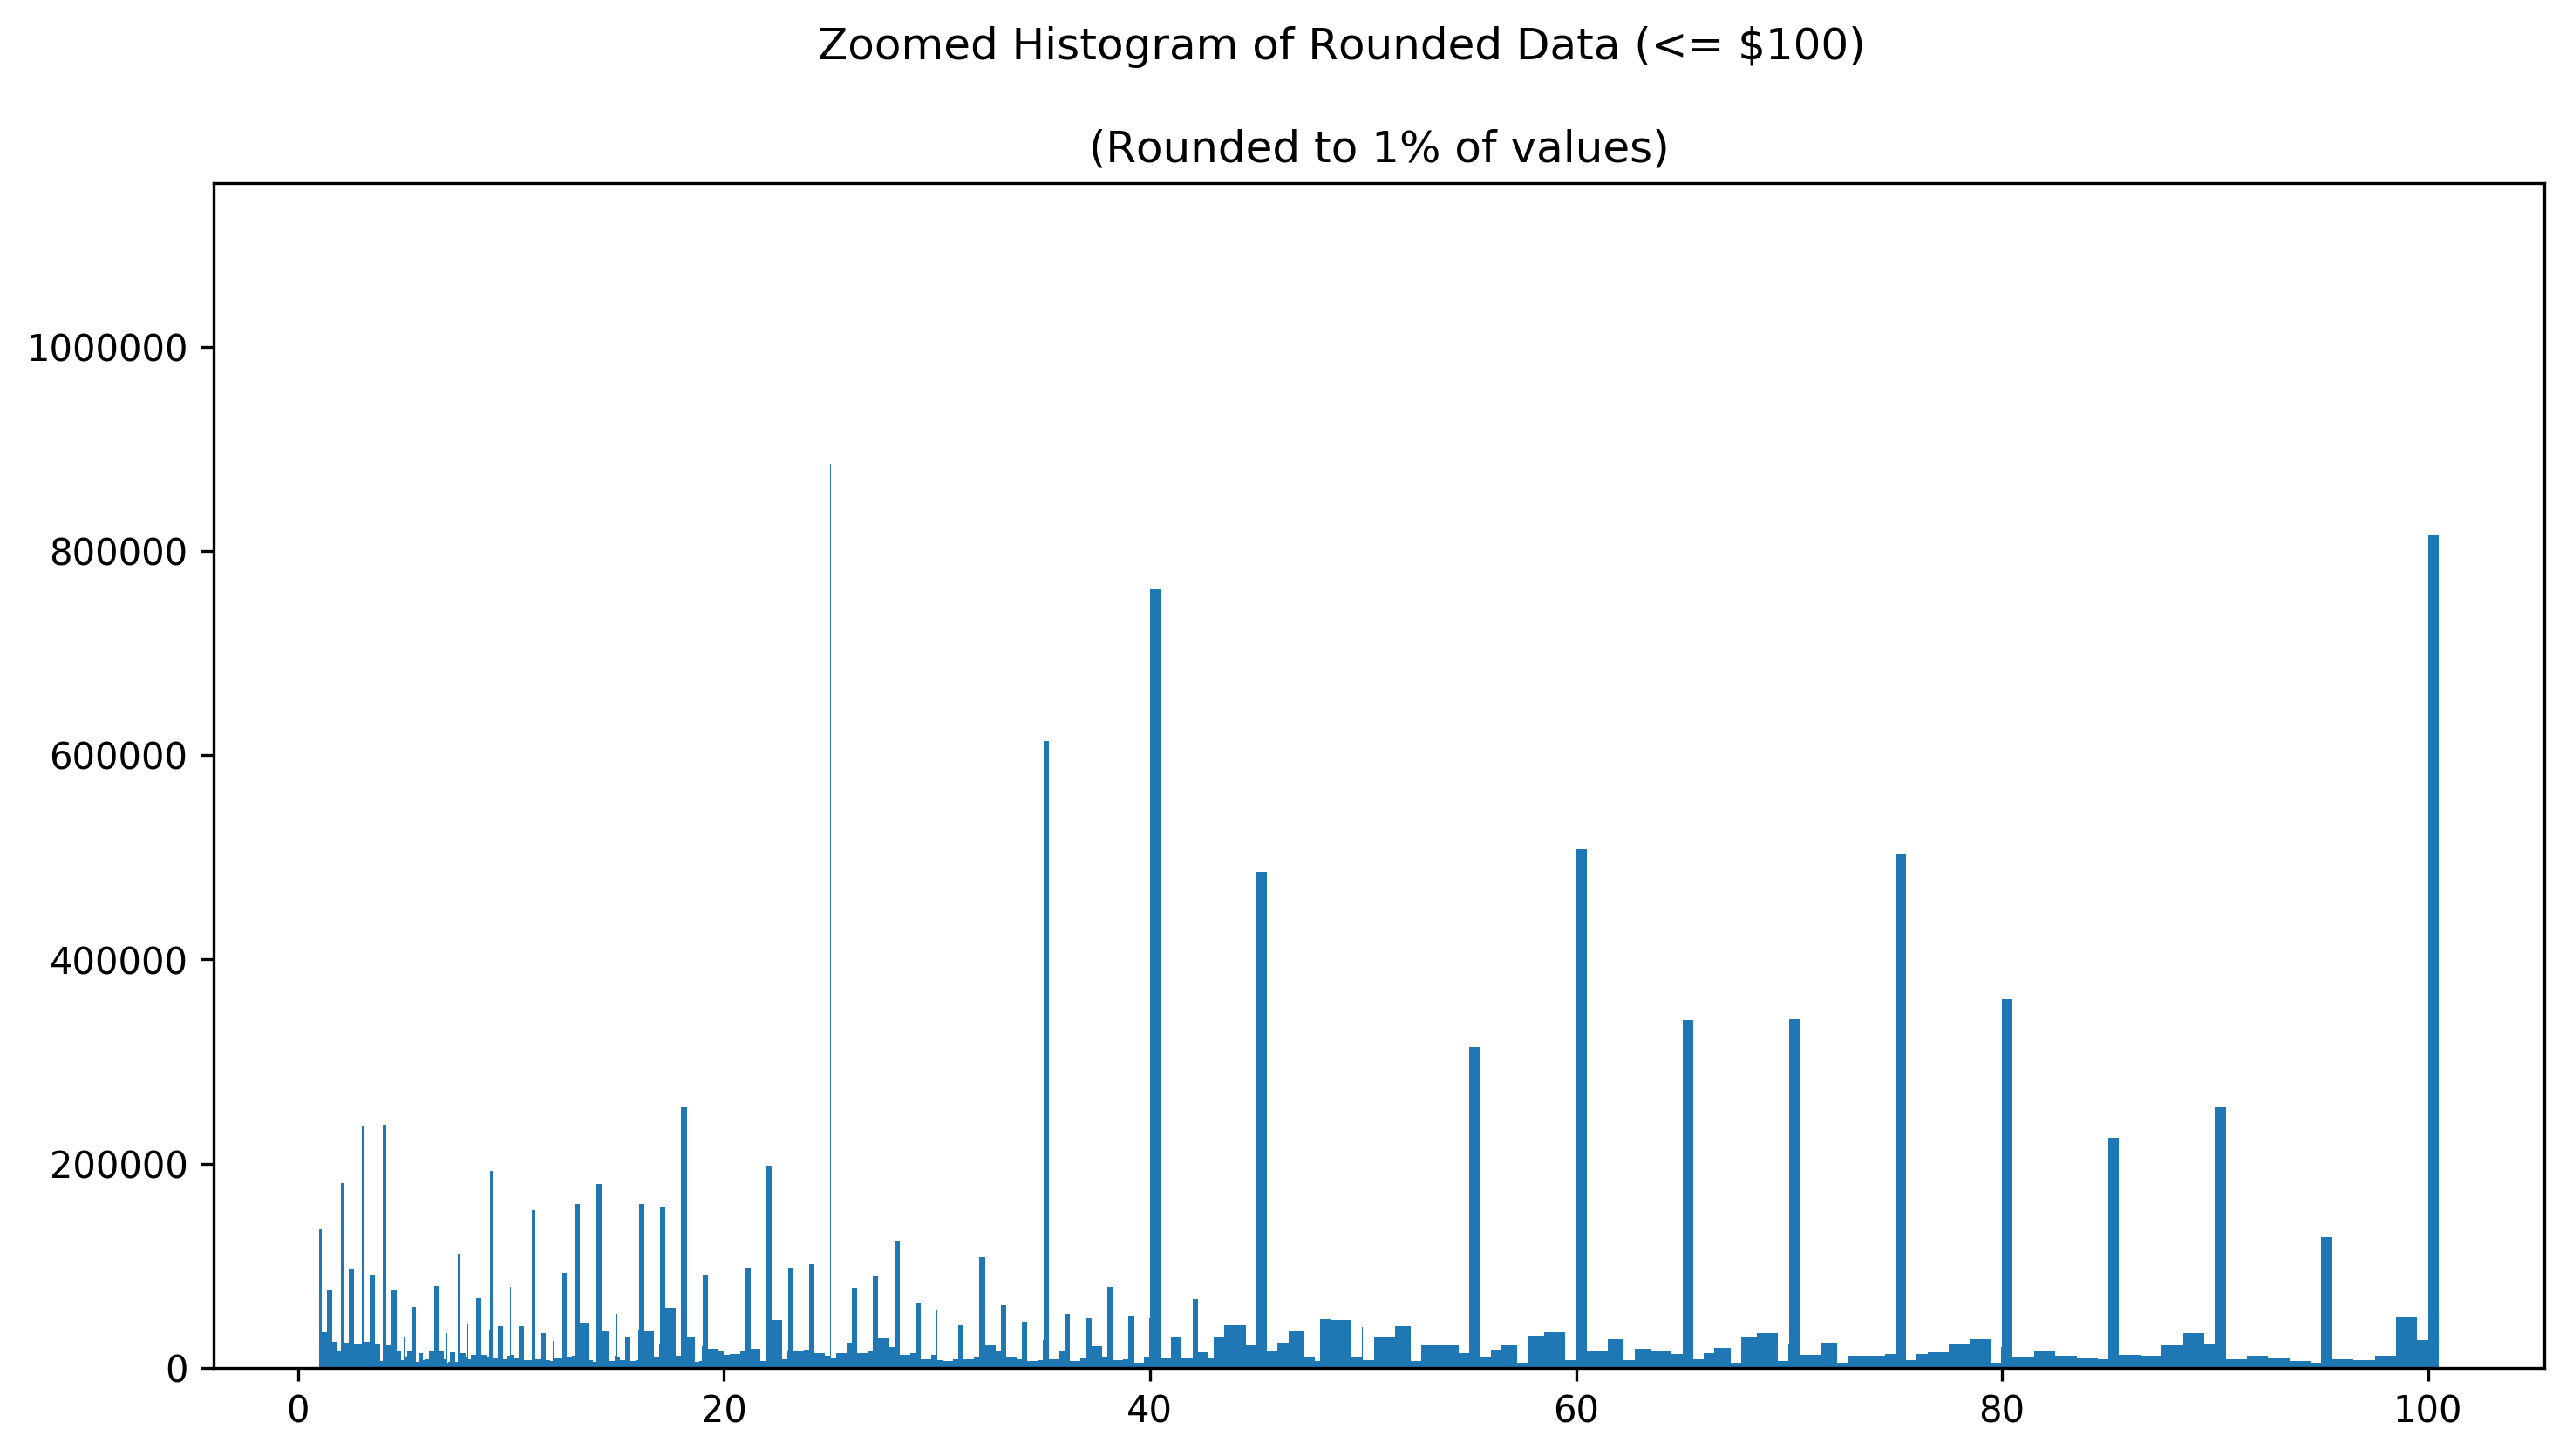

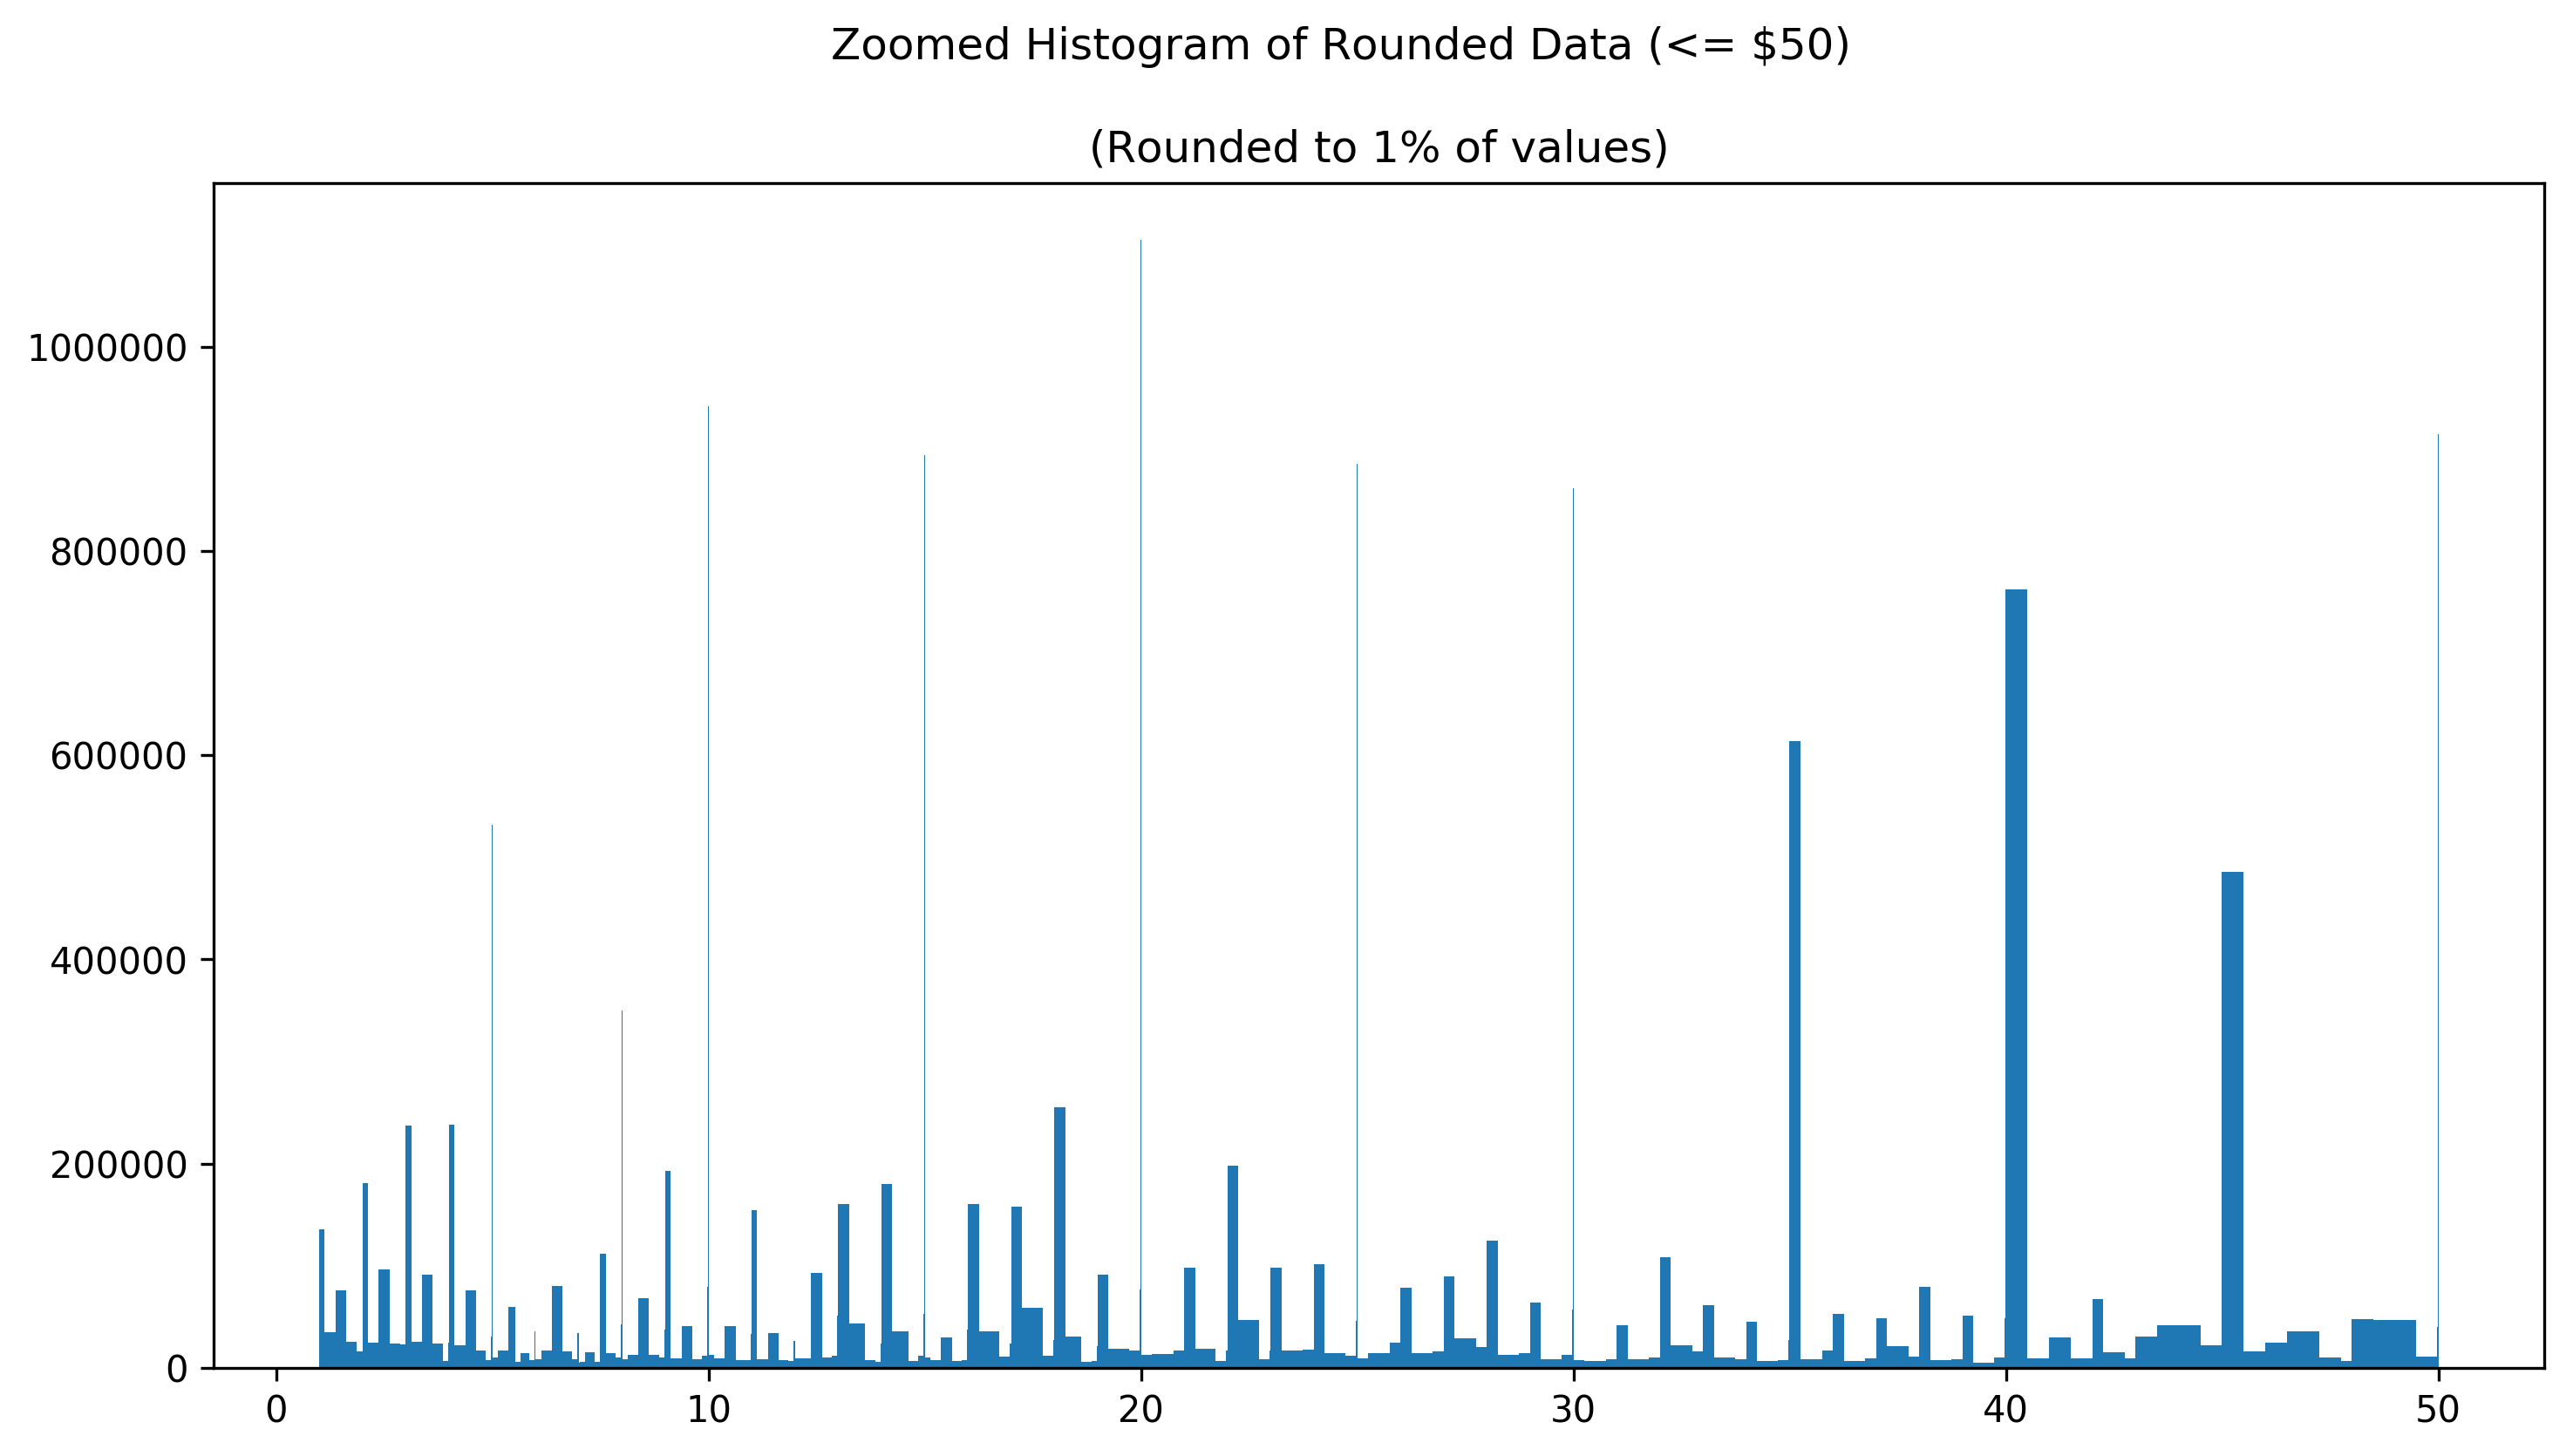

[1105405.  942053.  914540.  894061.  885651.  861661.  811876.  755958.
  609403.  578893.]


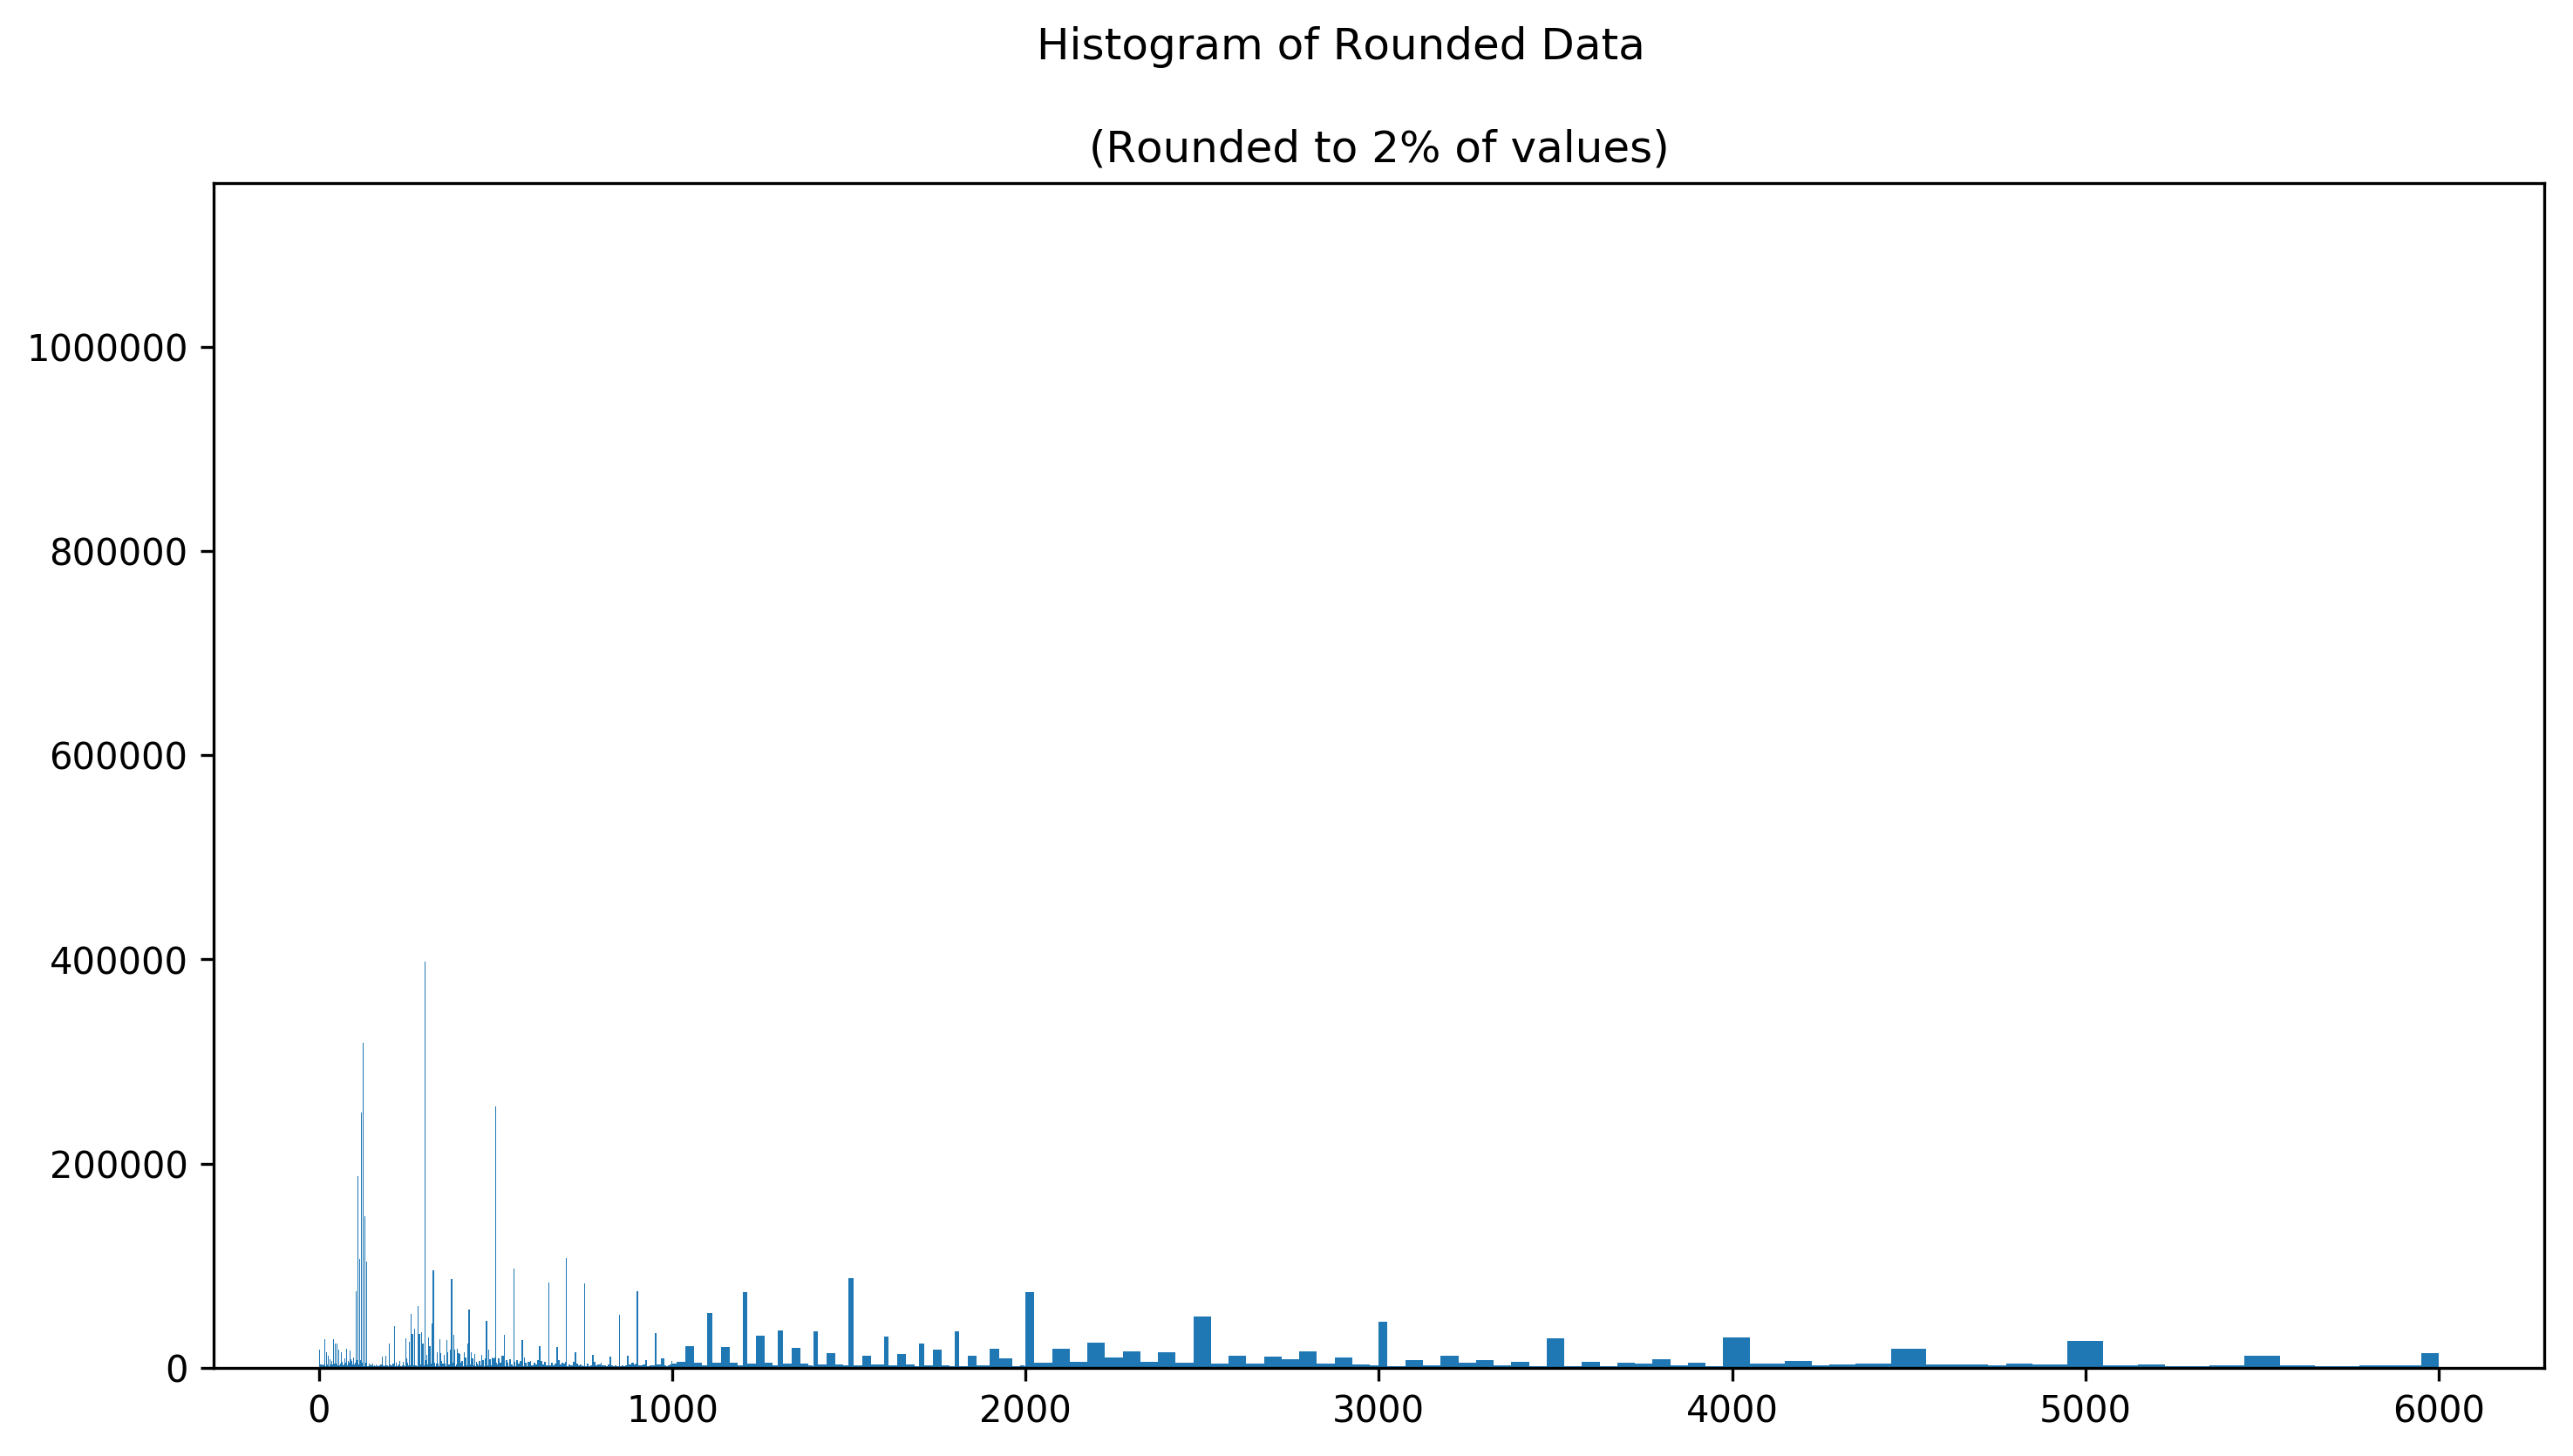

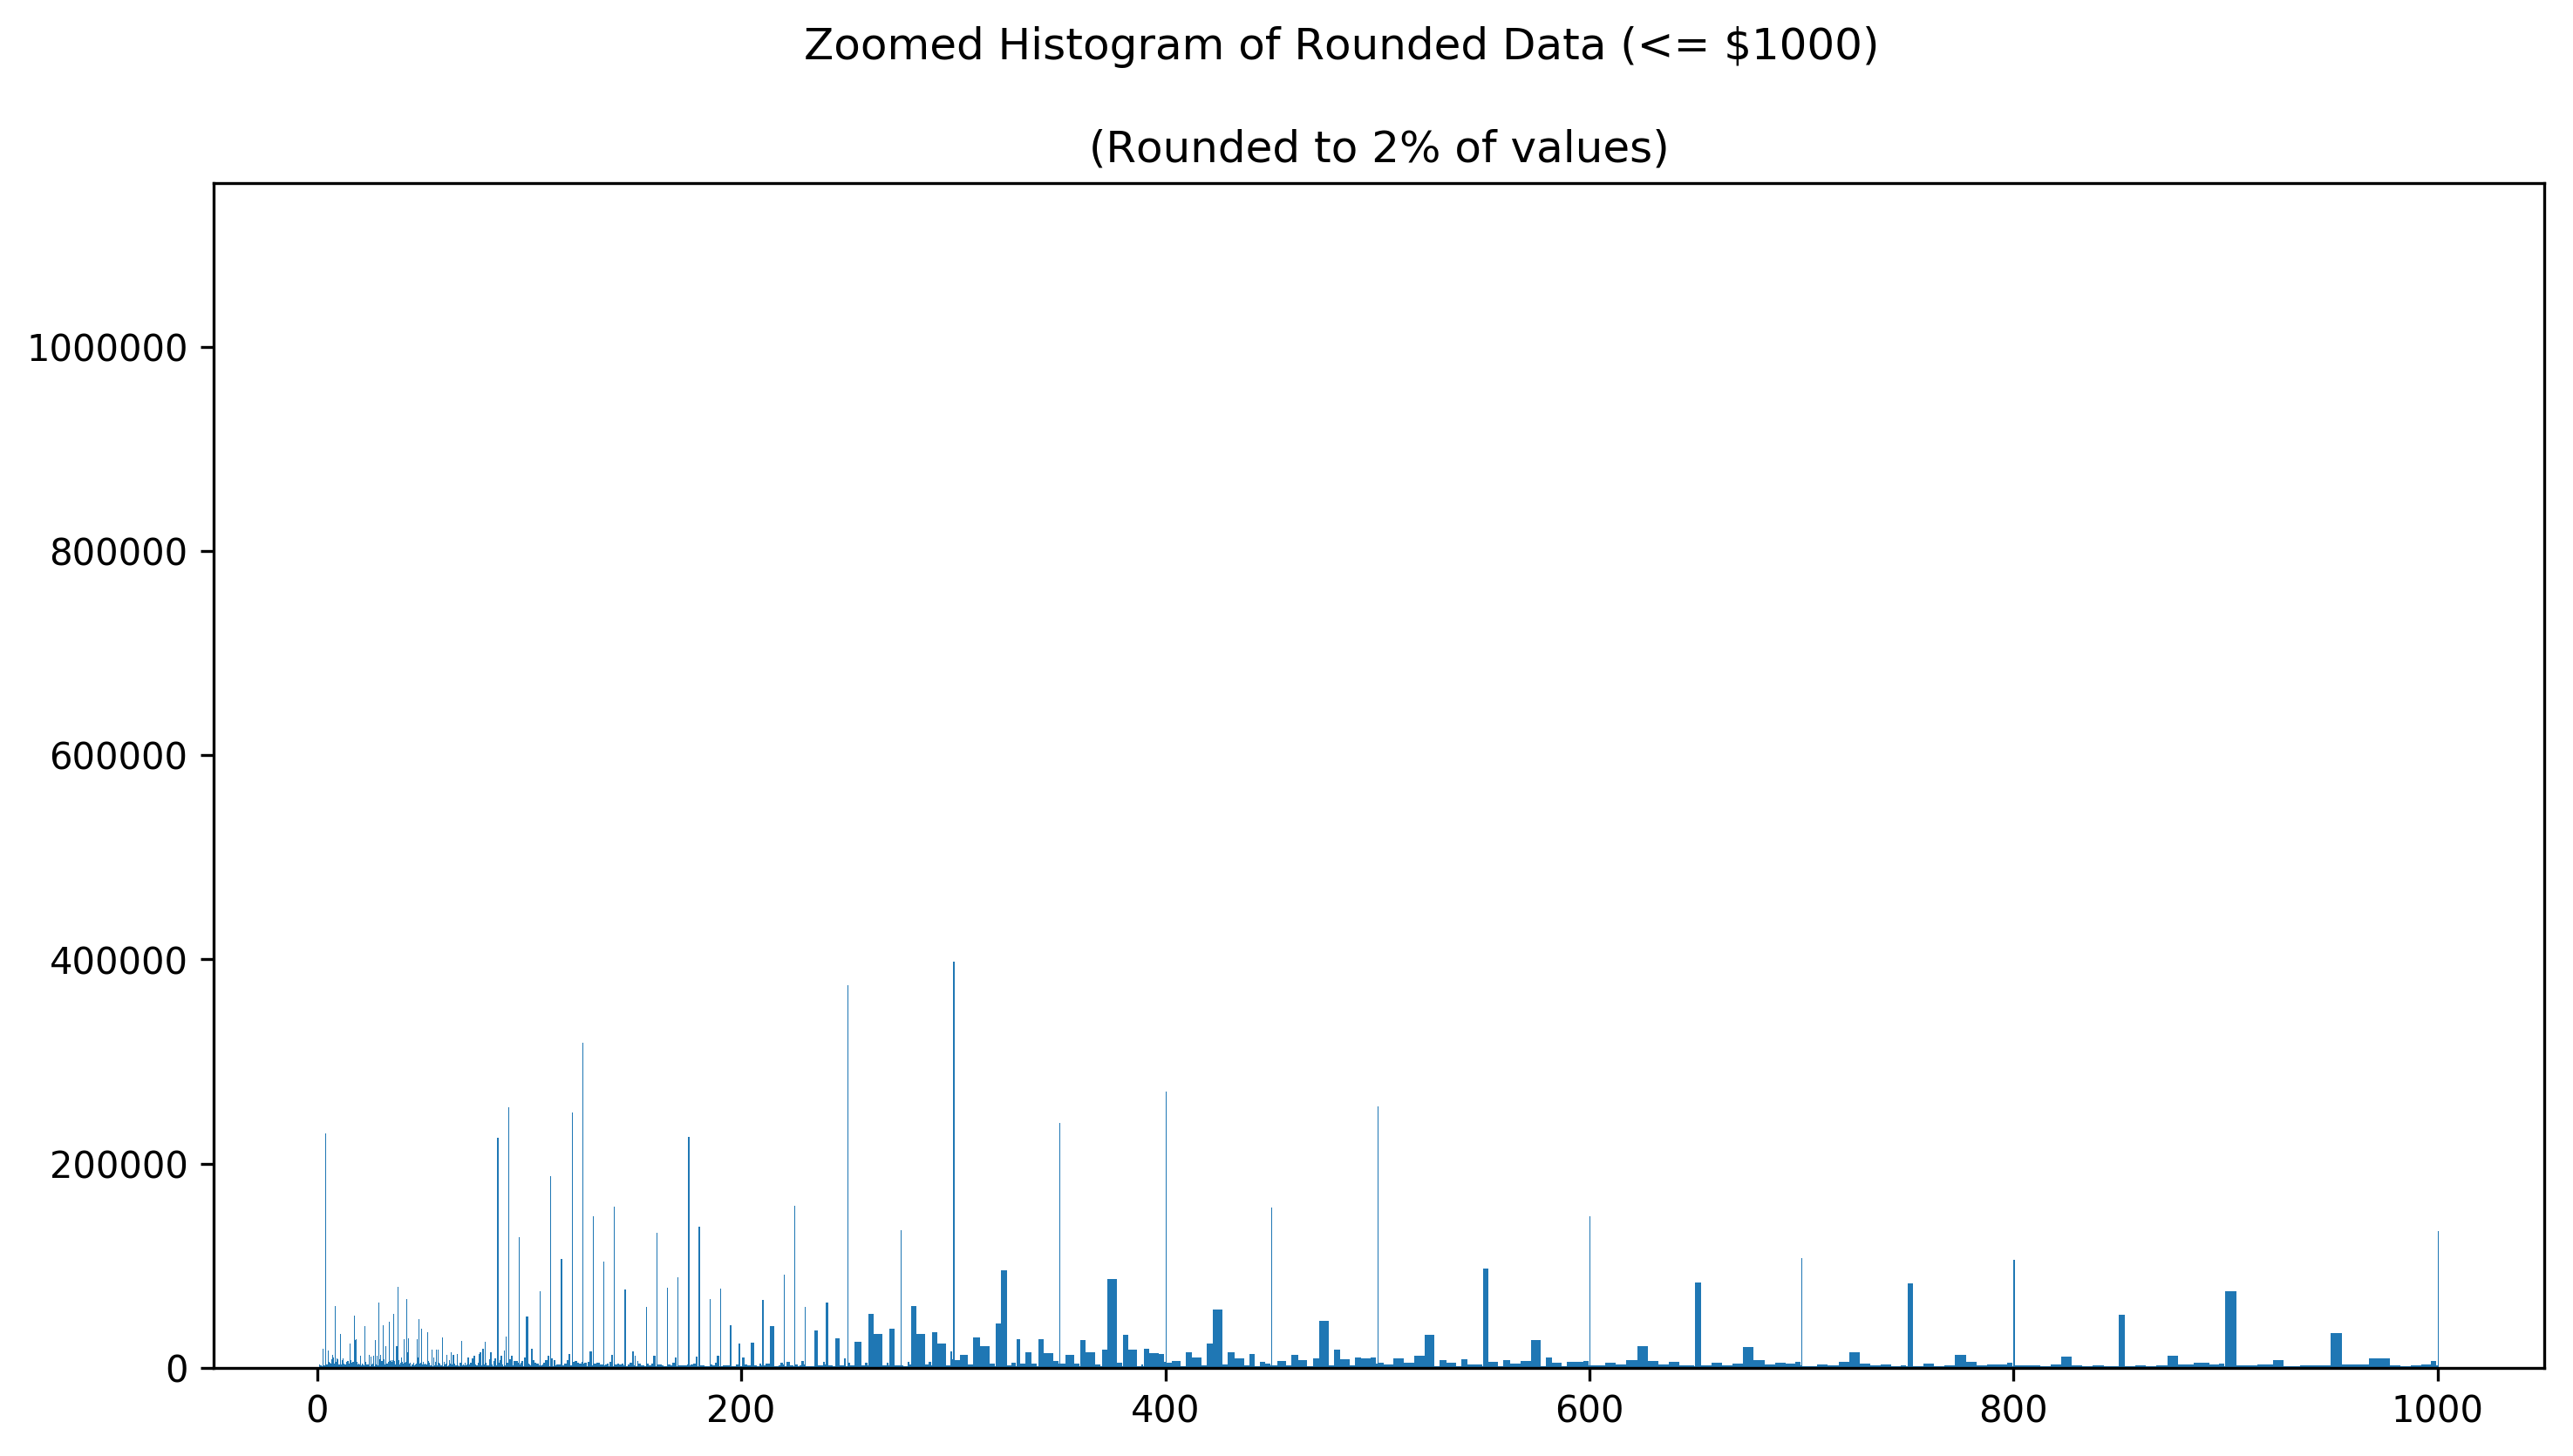

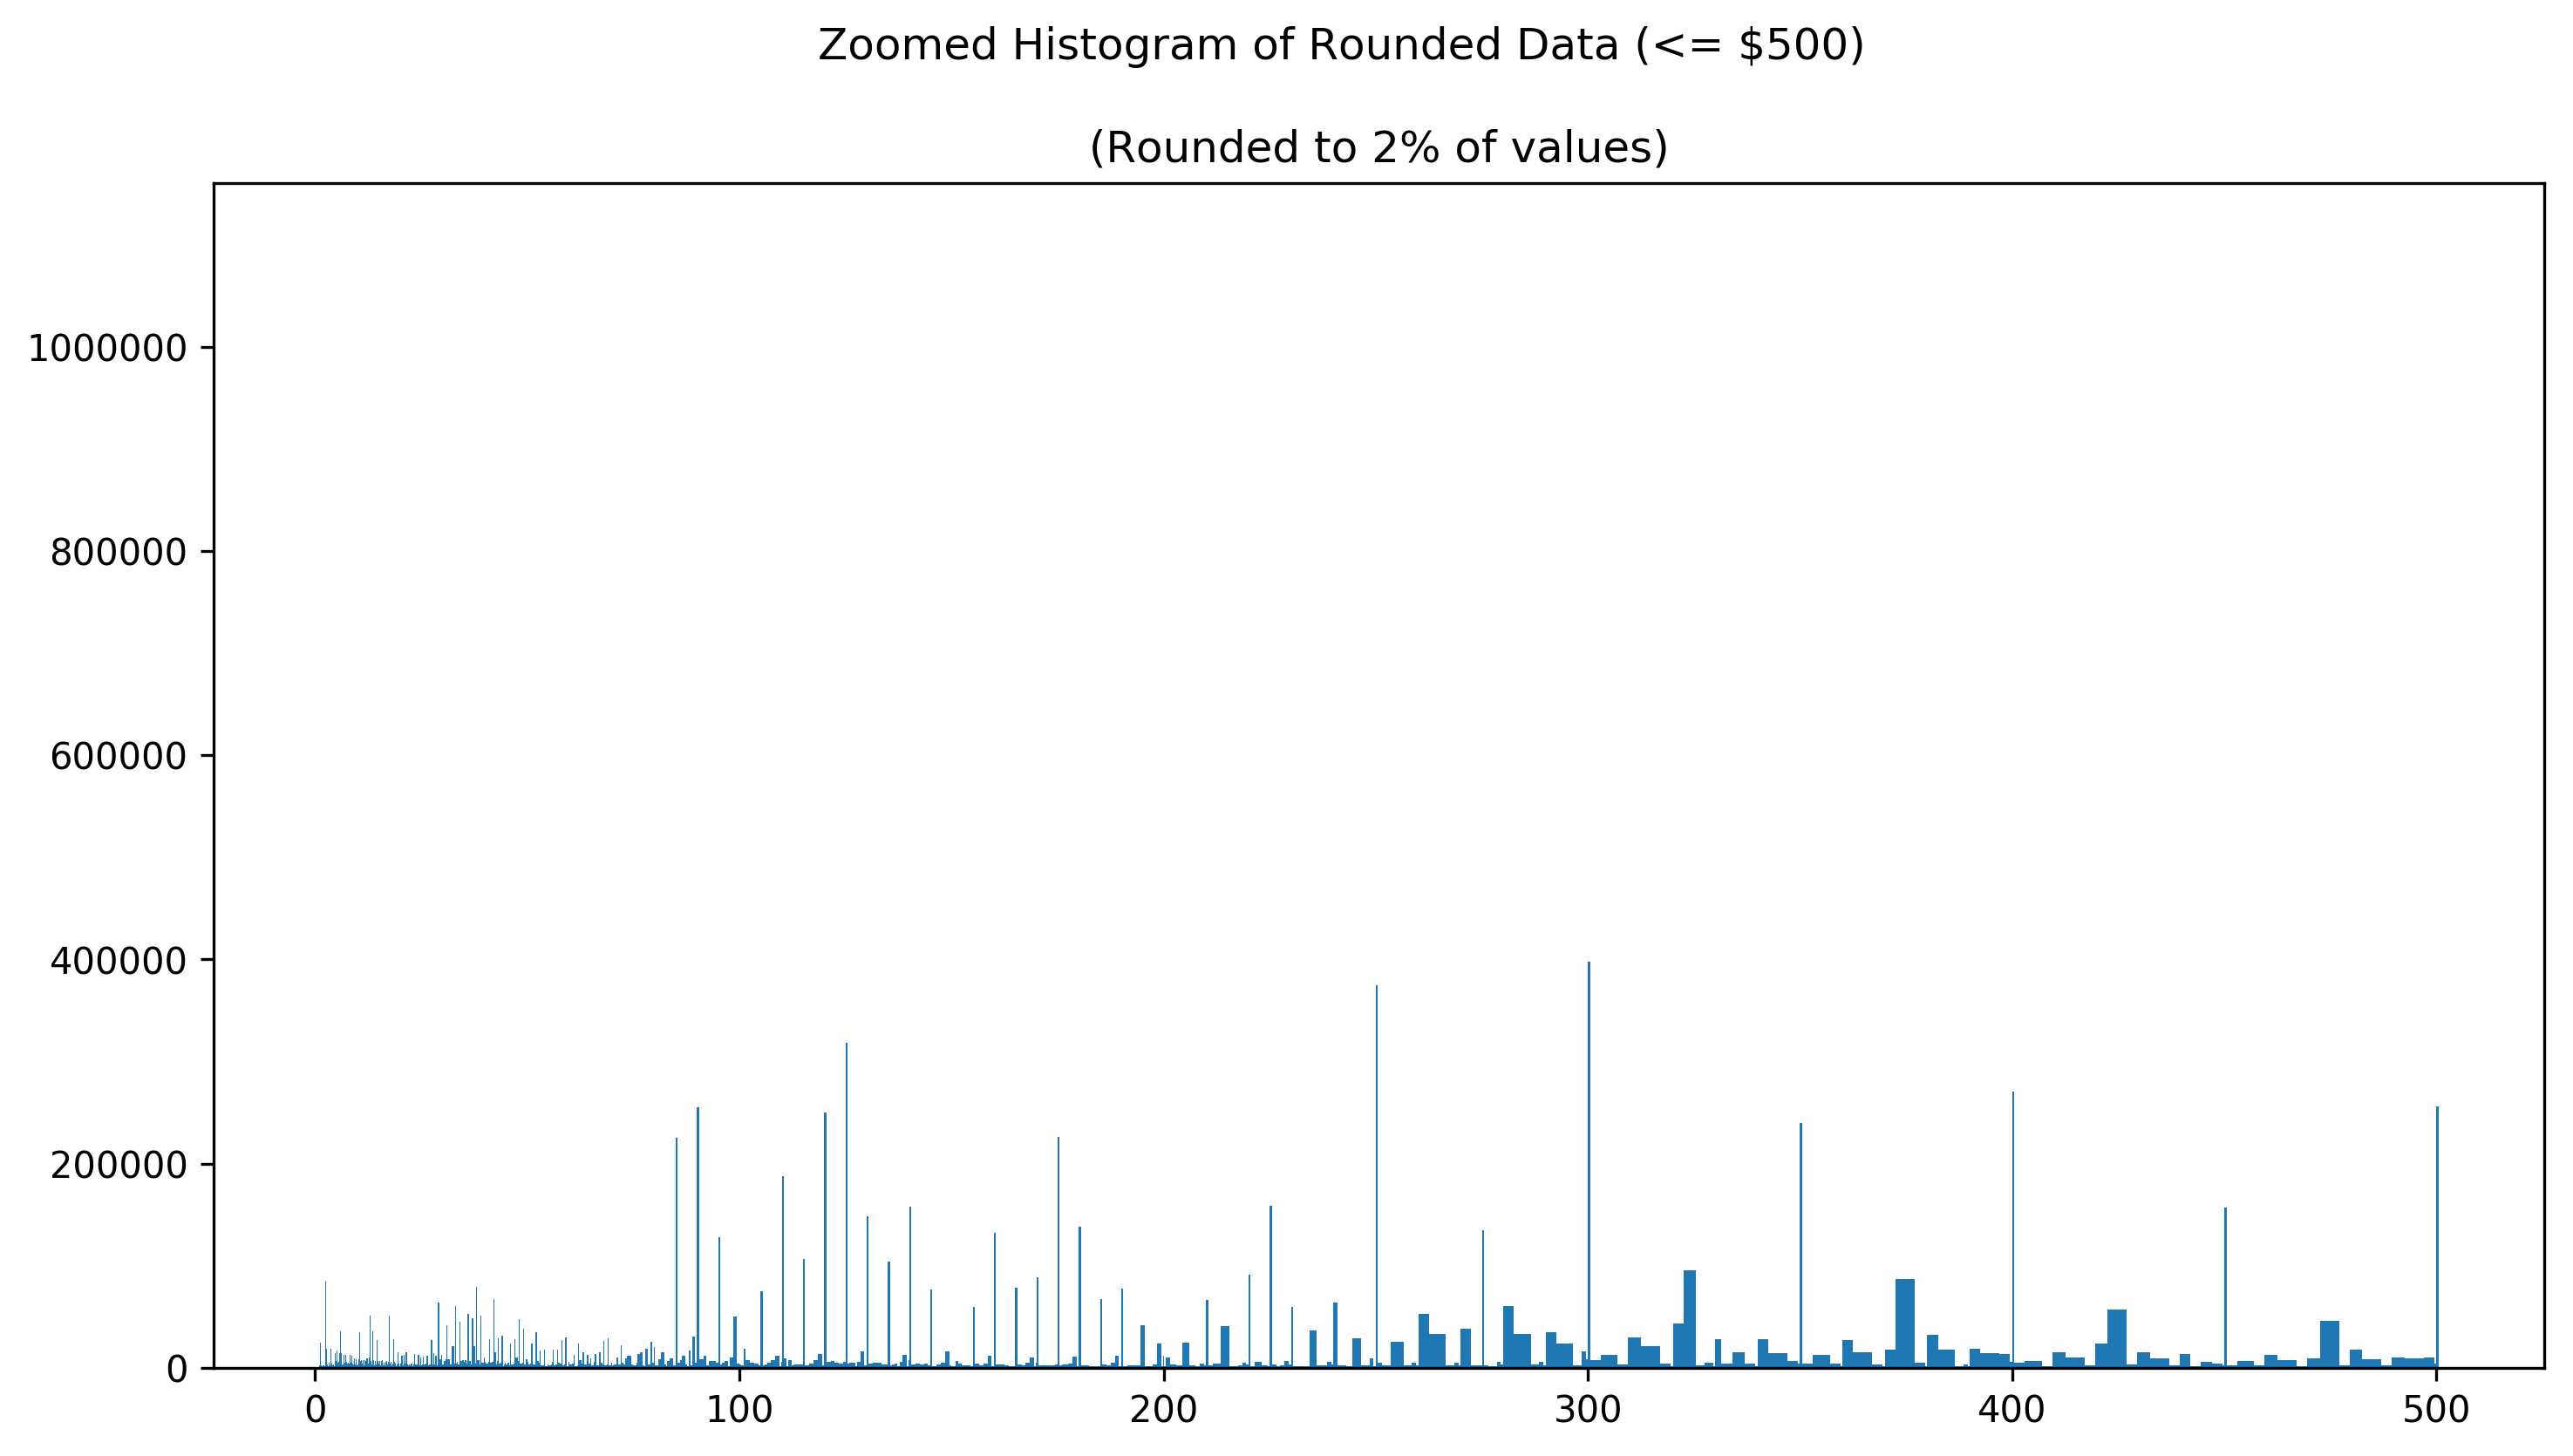

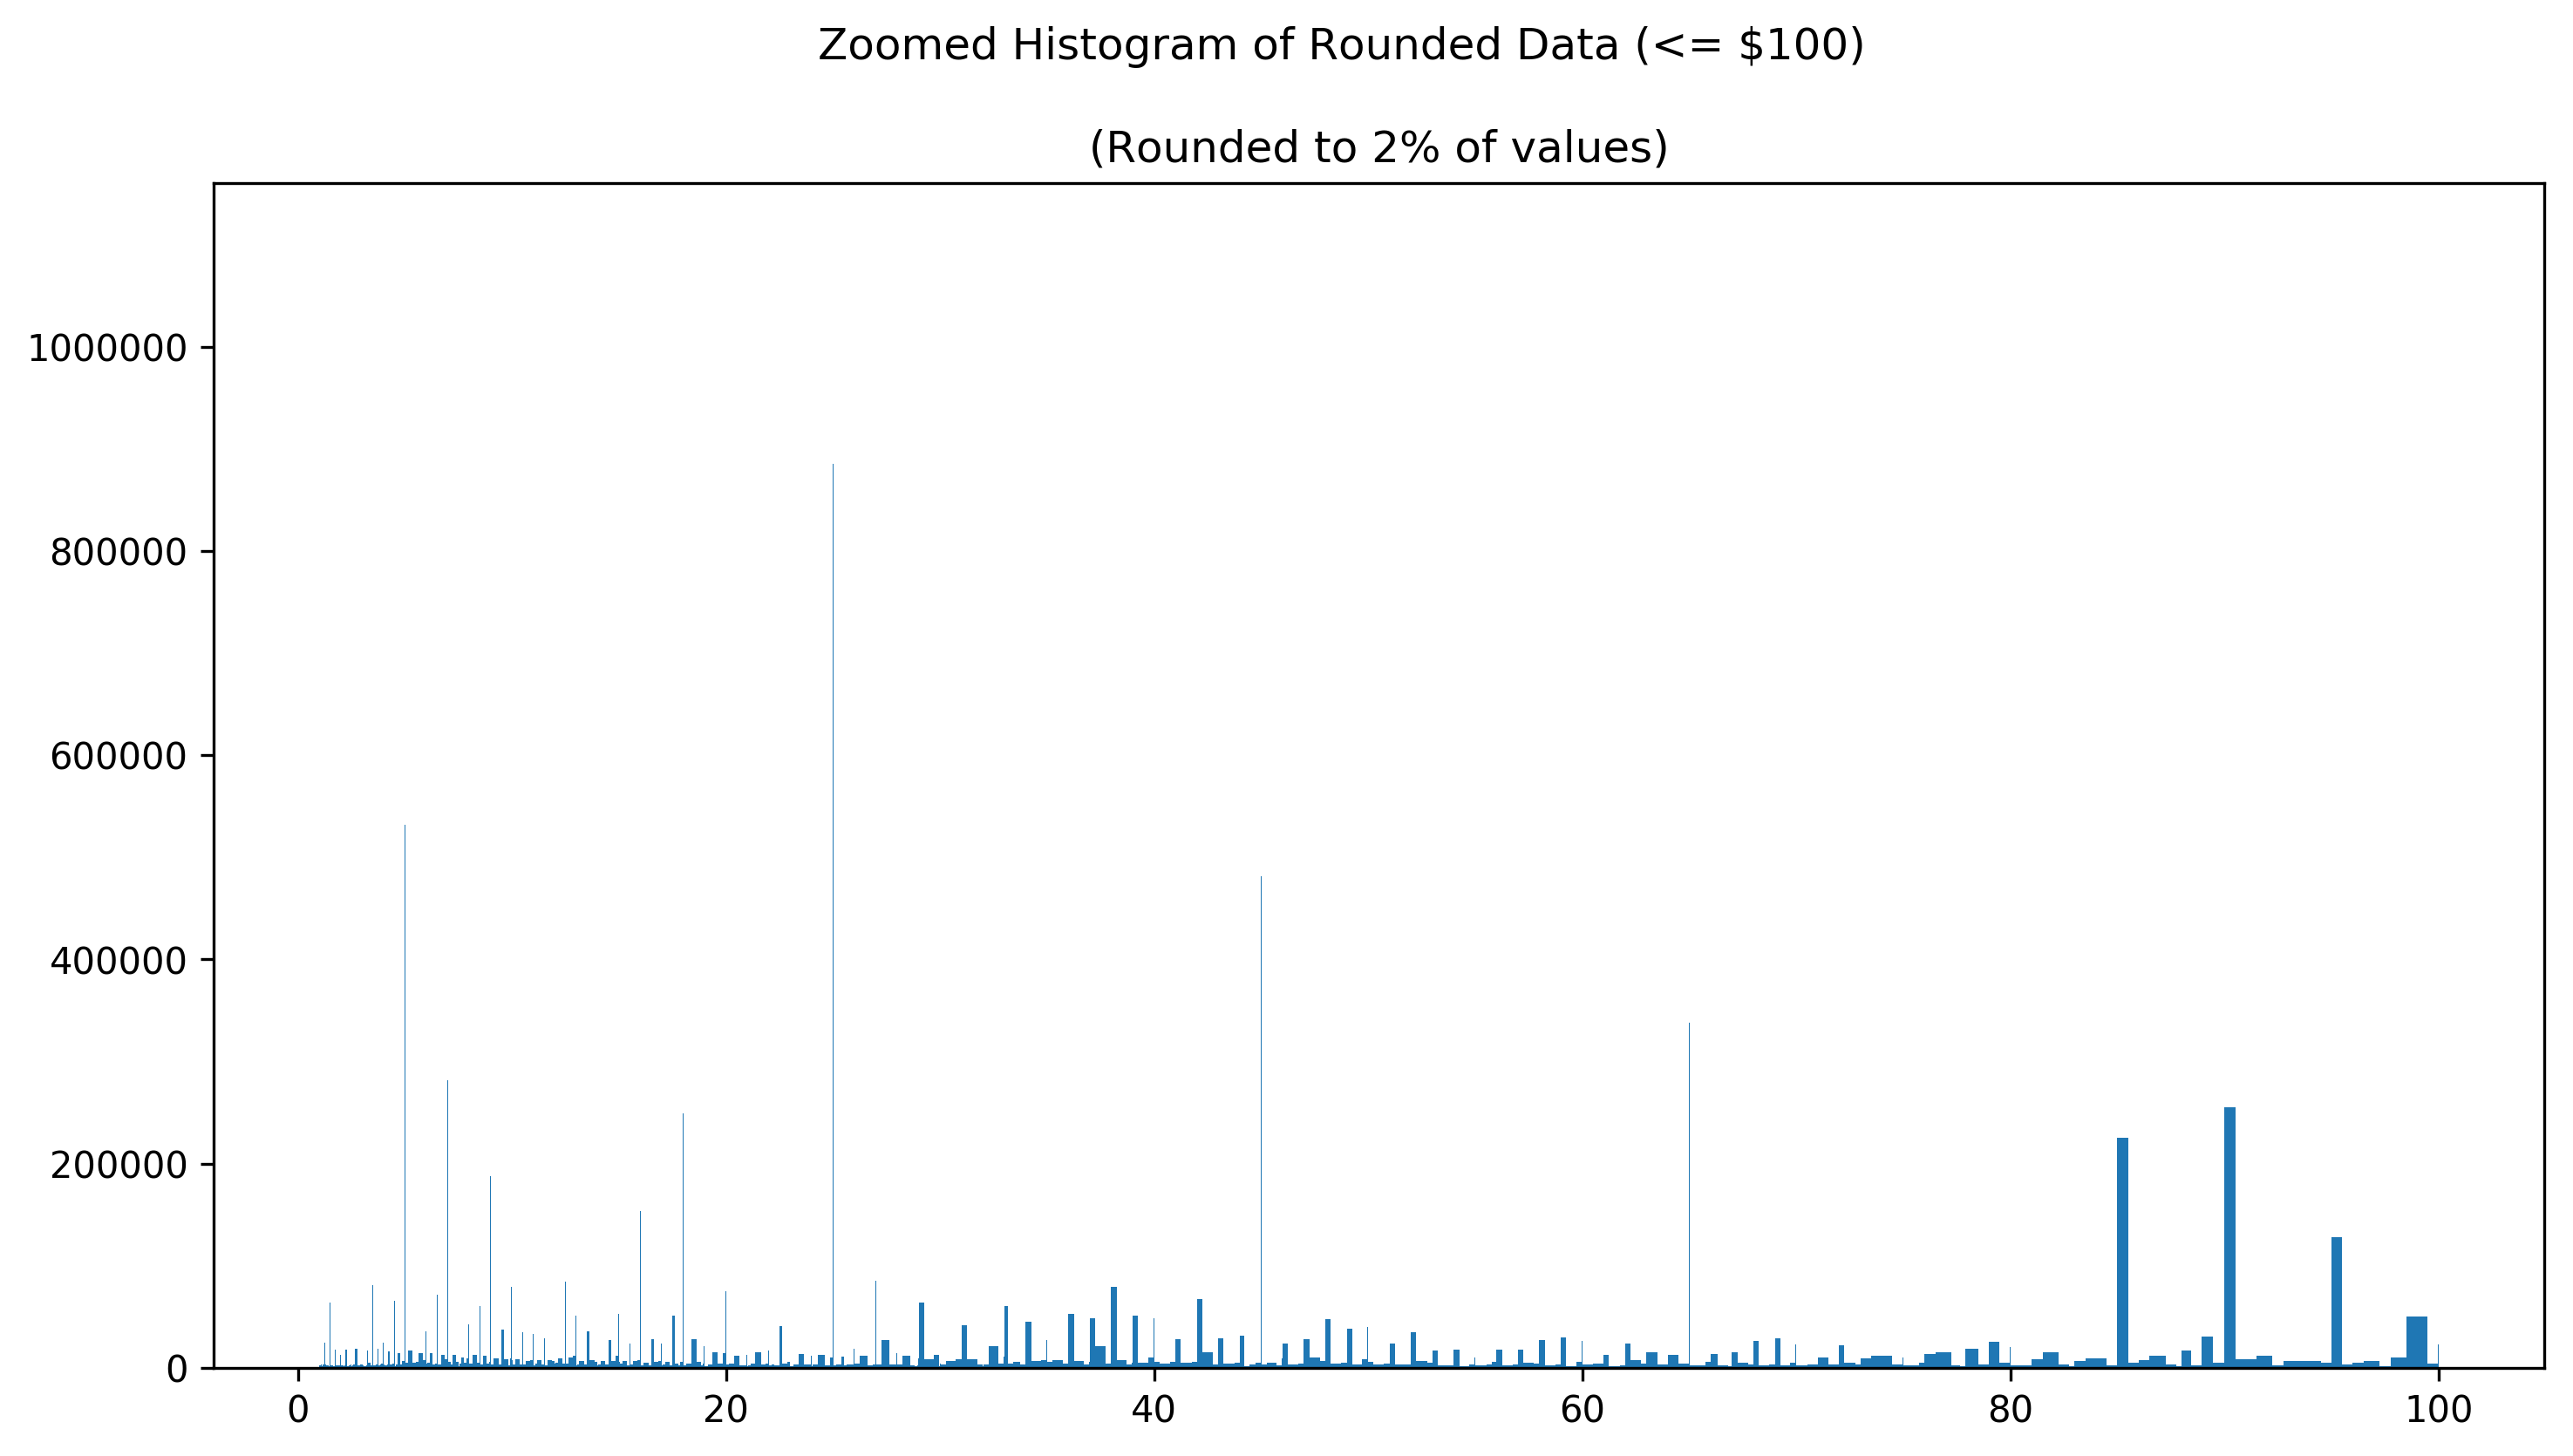

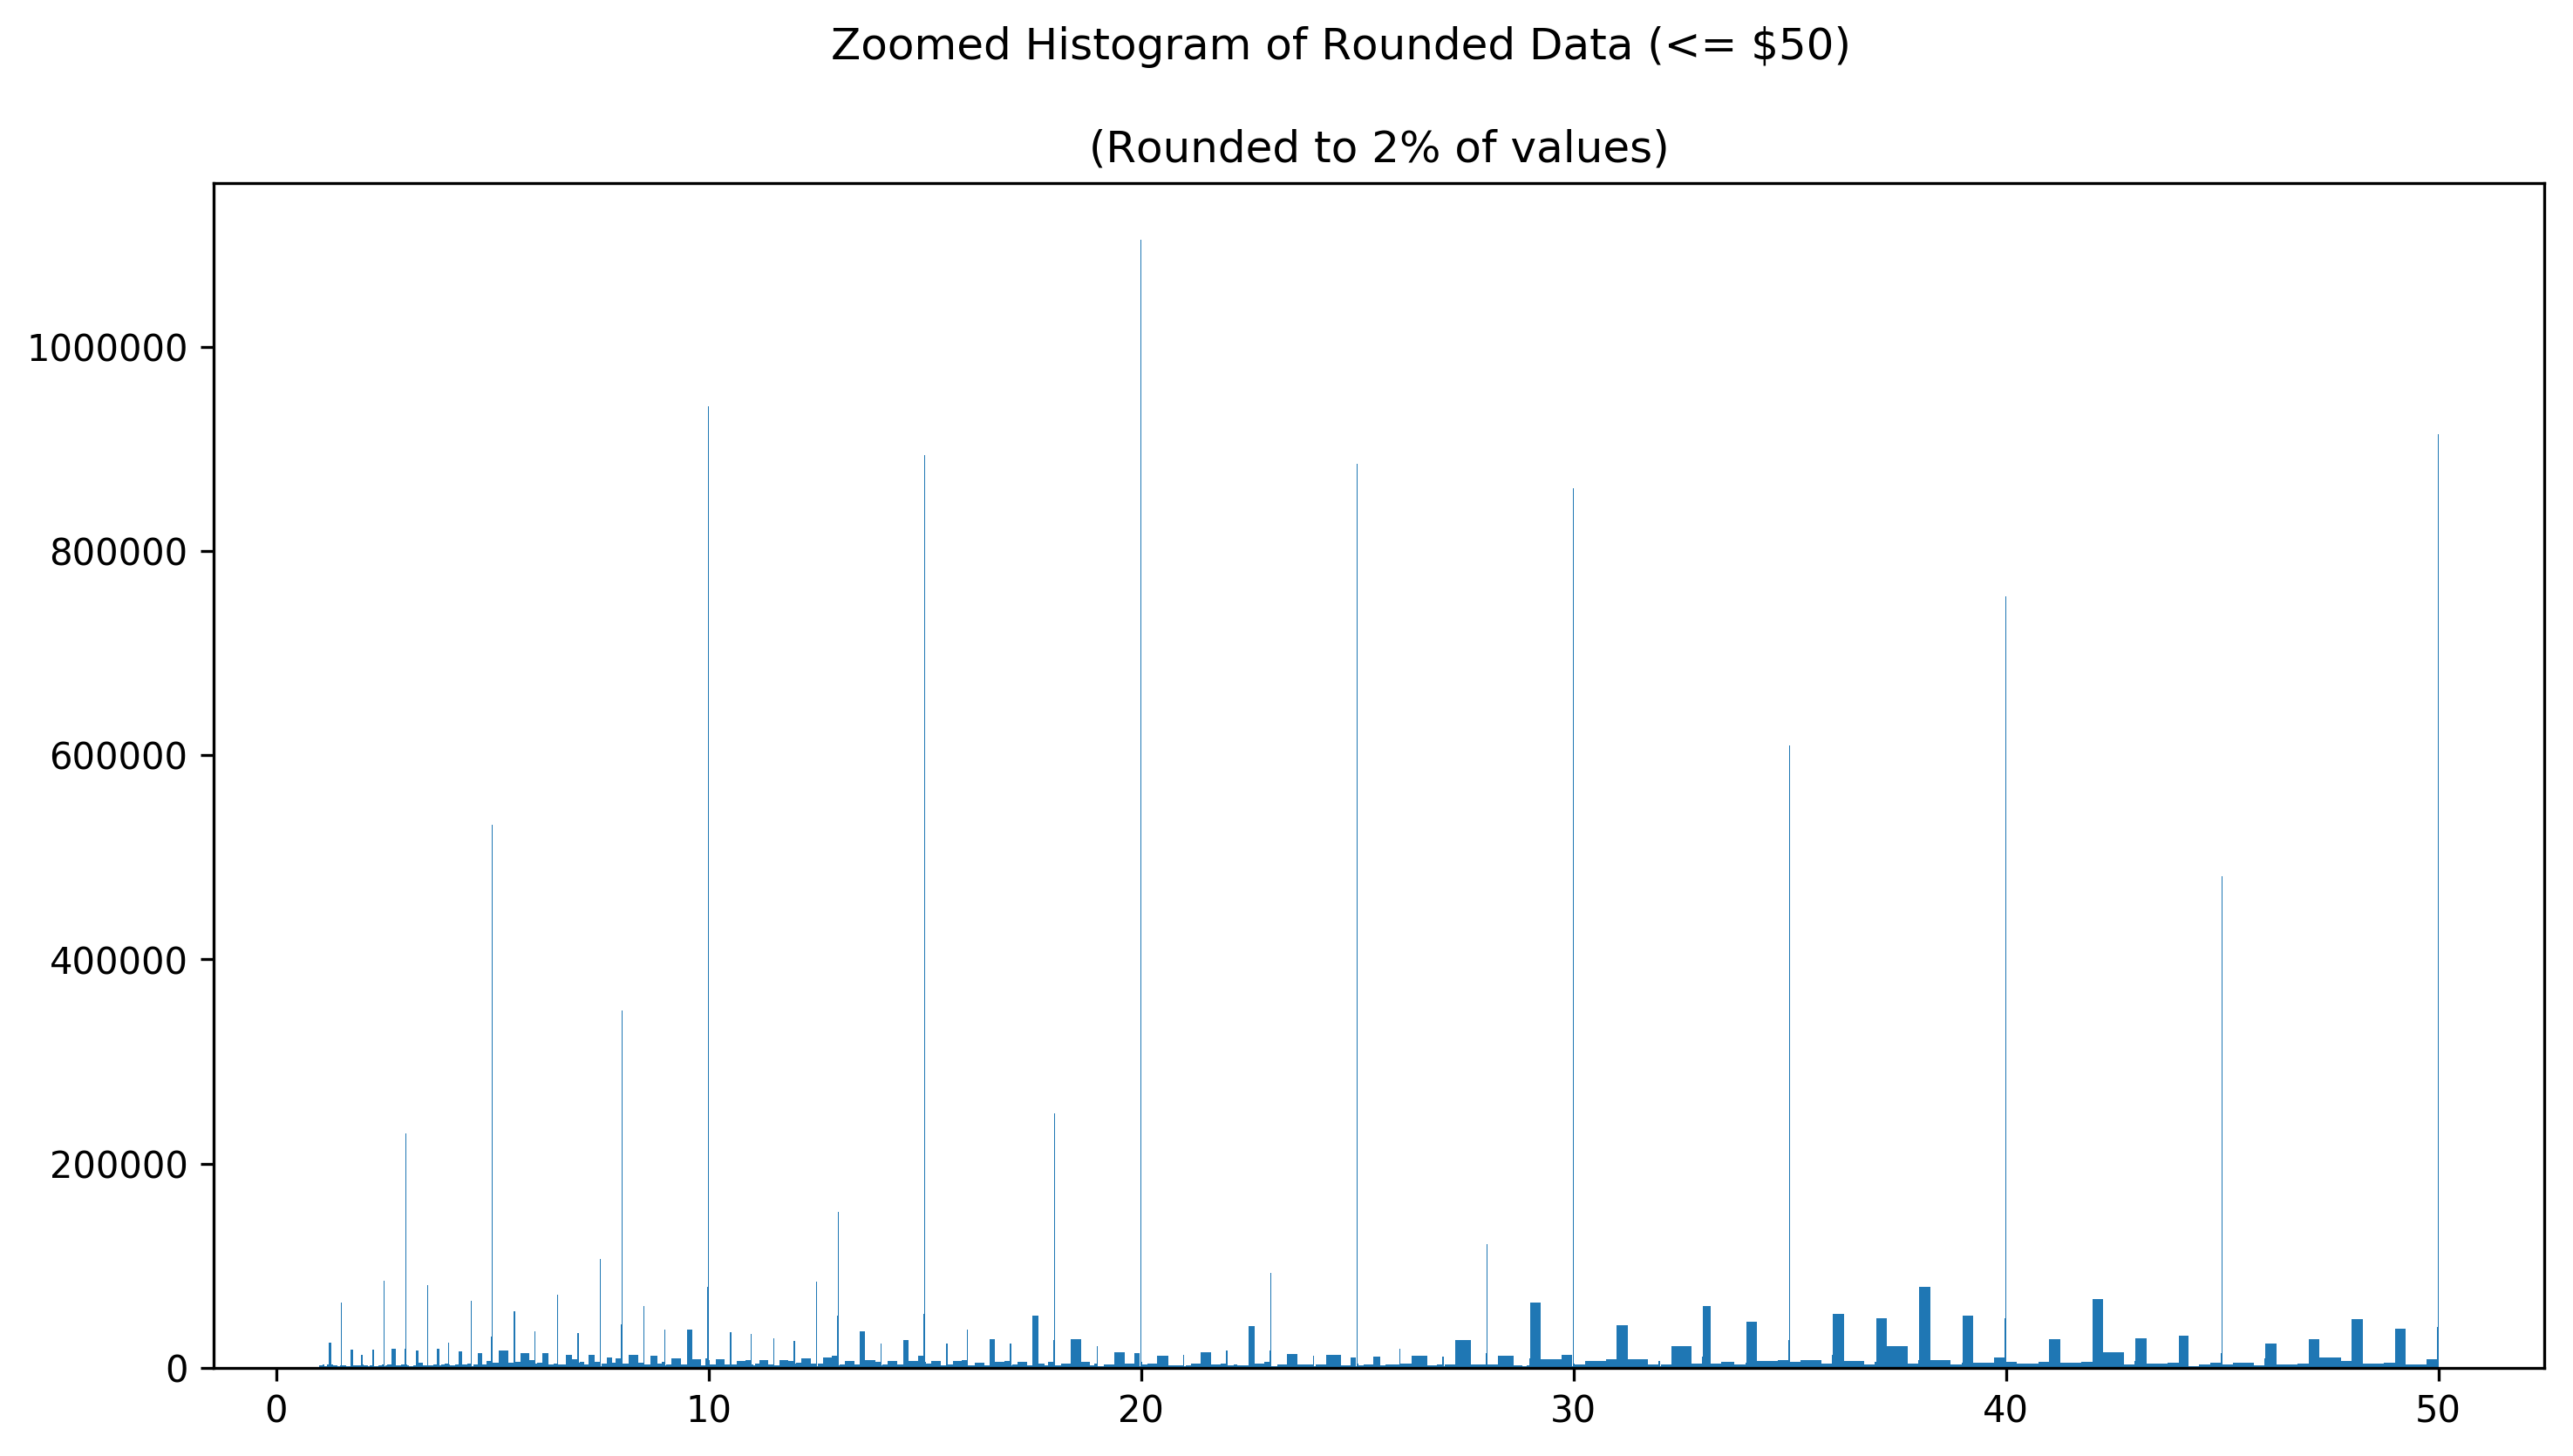

In [76]:
# constructing histograms that mimick the binning that
# would result from rounding the data to the top 1 or 2% of values
check_bins(cut_offr)